## PIRSense-Activity-Detection-via-PIR-Sensor-Data

### Overview of the dataset

So, with the dataset there is also a Introductory research paper given, link: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10081223&tag=1


So Initially we thought that it is not a time series dataset, so we did every calculation by keeping that in mind. <br>
But later after going through the paper we found out that the data is indeed time series, so we decided to use MLP & LSTM <br>



Data Collection:
The traditional passive infrared sensor(PIR) finds difficulty in sensing both stationary and moving occupants, hence they used custom designed SLEEPIR sensor nodes. Each node includes traditional PIR sensors and custom SLEEPIR modules. Each collects one observation every 30 seconds. Data includes raw voltage signals, PIR output, and derived features over sliding time windows.  


The obtained data set is a time series dataset, that is the date samples are related and mainly in chronological order. Date and Time depicts when the data is collected. <br> <br>
Labels: depict 0: Vacancy; 1: Stationary human presence; 3: Other activity/motion respectively.<br> <br> 

Temperature depicts the ambient temperature(°F) of the environment. Sensors work/ sense the animals or humans based on the temperature produced by them. PIRs are passive devices i.e., they themselves don't produce temperature. Hence the dataset includes the temperature of the environment and objects only. The PIR sensor feature stores raw analog readings from the sensor. Each value represents IR activity (motion/heat) detected over a short 4-second window.



Some Insights Derived from the Data

i. So, one thing we noticed is that a sensor is highly correlated with the sensor just adjacent to it, we also did some experiments with window sizes which is mentioned in detail further in this notebook <br>

ii. One Feature "Temperature_F" is very highly correlated with Label. <br>

iii. for a window size of 2 or more No feature is even moderately correlated with each other. <br>

iv. "Temperature_F" feature has only 6 unique values which is the least in the entire feature set. <br>

v. "Temperature_F" has the highest number of outliers among all the features. <br>

vi. The Dataset is not well balanced, like out of 7651 samples roughly 6247 samples are of class 0 itself


Overview of the Project

1. Helper.py -> So we have created a python file in which we have added all the necessary processing, plotting functions as well as MLP and LSTM models.

2. Data Pre-processing <br>
So we decided to Create 3 more datasets from the full dataset <br> <br>

A. Dataset Created by Manual Feature selection <br>
So We took these things into consideration for creating the manual datset <br>

i. Correlation Matrix <br>
ii. Heatmap <br>
iii. Variance Threshold <br>
iv. Information Gain <br>
v. Features with 0 Standard deviation <br>

Now after considering all the above mentioned principles we selected 20 features out of 56

B. So now to check how good is our feature selection we decided to compare it with standard feature selection libraries, so picked two libraries PCA & Feature engine

So we created a data set with PCA which consists of 20 features which matches the number of features we have manualy selected

C. Dataset created using the Feature Engine library. <br>
Feature engine is library which has inbuilt sub liraries like 

Missing data imputation
Encoding of categorical features
Discretization
Outlier capping or removal
Feature transformation
Creation of new features
Feature selection etc....

So from there Feature Selection library we used two models <br>
i. DropCorrelatedFeatures <br>
ii. SmartFeatureSelection <br>

Now the features selected by these 2 libraries are exactly same.
So we decided to create a dataset with these features

3. Models

When it comes to models we have chosen 2 Models <br>
i. MLP <br>
ii. LSTM <br>

Brief overview of the models <br>
i. MLP: <br>
    a. Architecure: Input Layer -> 64 -> 128 -> 64 -> 3 <br>
    b. Epochs: 75 <br> <br>
ii. LSTM<br>
    a. 64 Memory cells  -> 32 memory cells -> 3 (Dense) <br>
Batch size = 32 <br>
    b. Number of Timestep = 4 <br>

A detailed Explanation/ Justificaion of why we chose these architecures and other hyperparameters is given further in this notebook

4. Model performance

In brief <br>
MLP's are performing way better than LSTM's and also the time taken by MLP's is less compared to LSTM's <br>

So the evaluation function we chose MLP over LSTM 

Overall Analysis of MLP and LSTM Models Across Four Datasets <br>

The comparison between the MLP and LSTM models across four datasets—full dataset, manually selected features, PCA, and smart feature selection—highlights the consistent superiority of MLP in terms of accuracy, computational efficiency, stability, and class-specific performance. <br>

MLP achieves near-perfect accuracy (0.99) across all datasets and feature selection strategies, while LSTM struggles with lower accuracy, particularly under PCA (0.68), despite improving to 0.87 with smart feature selection. <br>

Precision and recall values further improves MLP's performance, as it maintains high scores across all classes, whereas LSTM faces significant challenges handling Class 1 effectively. <br> 
MLP is also far more computationally efficient, completing tasks in approximately 130 seconds across all datasets compared to LSTM's runtime exceeding 470 seconds. Additionally, MLP demonstrates exceptional stability with near-zero standard deviation across datasets, reflecting consistent predictions regardless of feature selection methods, while LSTM exhibits higher variability, especially under PCA (standard deviation of 0.36). <br>

In terms of F1 score, MLP delivers balanced and uniformly high scores for all classes and datasets, whereas LSTM performs well for Classes 0 and 3 but fails to handle Class 1 reliably. Although smart feature selection improves LSTM's performance, it still falls short compared to MLP's consistent excellence across all metrics and scenarios.

A detailed analysis of all the datasets and model evaluation is given in the end of the notebook

Install Pre-Requsites

In [ ]:
%pip install numpy pandas matplotlib seaborn missingno importlib-metadata scikit-learn tensorflow keras jinja2

Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import importlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.utils import to_categorical

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.19.0
GPU is NOT AVAILABLE


2025-04-13 20:08:04.462850: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


This is the evaluation function as mentioned in the DL_Project flier <br>

By Default the value of datafile_location and checkpoint is already set as required

In [5]:
datafile_location = "pirvision_office_dataset2.csv"
checkpoint = "Team_24.weights.h5"

def evaluate(datafile_location, checkpoint):
    import Helper
    processor = Helper.Processor()

    eval_data = pd.read_csv(datafile_location)
    eval_data = eval_data.drop(columns=["Date", "Time"])
    eval_labels, eval_data_without_label = processor.separate_label(data=eval_data)

    eval_data_without_label = processor.scaler(eval_data_without_label, "min_max")

    unique_labels = sorted(eval_labels.unique())

    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    y_mapped = np.array([label_mapping[label] for label in eval_labels])

    y_one_hot = to_categorical(y_mapped, num_classes=len(unique_labels))

    # Now using MLP
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(eval_data_without_label.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(unique_labels), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.load_weights(checkpoint)

    loss, accuracy = model.evaluate(eval_data_without_label, y_one_hot)
    print(f"\n\nAccuracy is {accuracy}")

    return accuracy

evaluate(datafile_location, checkpoint)


/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0284


Accuracy is 0.9921578764915466


0.9921578764915466

Loading the data and storing it in pandas dataframe

In [4]:
df1 = pd.read_csv("pirvision_office_dataset1.csv")
df2 = pd.read_csv("pirvision_office_dataset2.csv")
data = pd.concat([df1,df2], ignore_index=True)

# Sorting the data according to the data and time
data = data.sort_values(by=['Date', 'Time'], ascending=True)

print(data.head())
print(data.shape[0])

            Date      Time  Label  Temperature_F  PIR_1  PIR_2  PIR_3  PIR_4  \
0     2024-08-08  19:19:56      0             86  10269  10721  11156  11170   
7651  2024-08-08  19:19:56      0             86  10269  10721  11156  11170   
1     2024-08-08  19:20:12      1             86  10364  10907  11299  11238   
7652  2024-08-08  19:20:12      1             86  10364  10907  11299  11238   
2     2024-08-08  19:20:28      0             86  10329  10793  11197  11242   

      PIR_5  PIR_6  ...  PIR_46  PIR_47  PIR_48  PIR_49  PIR_50  PIR_51  \
0     10931  10671  ...   11178   11197   11161   11096   10957   10839   
7651  10931  10671  ...   11178   11197   11161   11096   10957   10839   
1     10867  10535  ...   11122   11145   11136   11108   11041   10824   
7652  10867  10535  ...   11122   11145   11136   11108   11041   10824   
2     11052  10658  ...   11168   11204   11162   11109   11007   10867   

      PIR_52  PIR_53  PIR_54  PIR_55  
0      10735   10590   10411 

In [5]:
#Dropping Date and Time column
data = data.drop(columns=["Date", "Time"])

Importing the custom class

In [6]:
# Init the Processor
import Helper

importlib.reload(Helper)
processor = Helper.Processor()
plotter = Helper.Plotter(plt=plt,sns=sns)
models = Helper.Models()


def reload_helper():
    global processor, plotter, models
    importlib.reload(Helper)
    processor = Helper.Processor()
    plotter = Helper.Plotter(plt=plt,sns=sns)
    models = Helper.Models()

Overview of all the features

In [7]:
data.describe().transpose()

count           mean           std     min       25%  \
Label          15302.0       0.332767  8.184507e-01     0.0      0.00   
Temperature_F  15302.0      80.383871  2.286067e+01     0.0     86.00   
PIR_1          15302.0  250125.620572  4.292858e+06  2613.0  10333.00   
PIR_2          15302.0   11013.891648  5.917799e+02  2615.0  10787.25   
PIR_3          15302.0   11517.838452  6.566624e+02  2614.0  11272.25   
PIR_4          15302.0   11578.490786  6.630902e+02  2611.0  11338.00   
PIR_5          15302.0   11269.104169  6.059163e+02  2612.0  11051.00   
PIR_6          15302.0   10795.036989  5.372303e+02  2613.0  10629.00   
PIR_7          15302.0   10312.208600  5.013907e+02  2616.0  10182.00   
PIR_8          15302.0    9907.840413  4.996161e+02  2614.0   9764.00   
PIR_9          15302.0    9610.574958  5.220129e+02  2615.0   9410.00   
PIR_10         15302.0    9421.211214  5.502803e+02  2614.0   9162.00   
PIR_11         15302.0    9327.678212  5.681547e+02  2611.0   9043.00   
PIR_12         15302.0    9311.812181  5.770953e+02  2605.0   9028.00   
PIR_13         15302.0    9355.004313  5.647378e+02  2602.0   9087.00   
PIR_14         15302.0    9442.985753  5.567733e+02  2603.0   9206.00   
PIR_15         15302.0    9557.784211  5.427135e+02  2611.0   9354.00   
PIR_16         15302.0    9685.499673  5.391728e+02  2613.0   9513.00   
PIR_17         15302.0    9815.936871  5.369889e+02  2614.0   9674.00   
PIR_18         15302.0    9939.873742  5.255946e+02  2613.0   9831.00   
PIR_19         15302.0   10052.869560  5.056914e+02  2612.0   9965.00   
PIR_20         15302.0   10150.338256  4.900986e+02  2612.0  10078.00   
PIR_21         15302.0   10232.754411  4.887468e+02  2613.0  10172.00   
PIR_22         15302.0   10300.758724  4.826378e+02  2614.0  10242.00   
PIR_23         15302.0   10353.762776  4.785489e+02  2614.0  10295.00   
PIR_24         15302.0   10395.873611  4.765164e+02  2618.0  10336.00   
PIR_25         15302.0   10425.507777  4.659629e+02  2619.0  10364.00   
PIR_26         15302.0   10444.600444  4.742906e+02  2618.0  10381.00   
PIR_27         15302.0   10456.671546  4.841883e+02  2615.0  10392.00   
PIR_28         15302.0   10460.038296  4.908837e+02  2615.0  10398.00   
PIR_29         15302.0   10454.110051  4.945591e+02  2615.0  10394.00   
PIR_30         15302.0   10446.378905  4.859548e+02  2615.0  10390.00   
PIR_31         15302.0   10437.645014  4.798755e+02  2614.0  10382.00   
PIR_32         15302.0   10427.139067  4.878100e+02  2613.0  10374.00   
PIR_33         15302.0   10416.795190  5.002626e+02  2614.0  10366.00   
PIR_34         15302.0   10406.123383  5.024185e+02  2614.0  10354.00   
PIR_35         15302.0   10395.103516  4.944825e+02  2612.0  10343.00   
PIR_36         15302.0   10382.407921  4.785885e+02  2614.0  10331.00   
PIR_37         15302.0   10240.095543  4.861134e+02  2609.0  10152.00   
PIR_38         15302.0    9643.828127  5.838509e+02  2611.0   9399.00   
PIR_39         15302.0    8959.425042  6.797927e+02  2612.0   8566.00   
PIR_40         15302.0    8717.708535  7.217056e+02  2612.0   8236.00   
PIR_41         15302.0    8986.531957  6.691027e+02  2612.0   8618.00   
PIR_42         15302.0    9561.237616  5.607715e+02  2611.0   9323.25   
PIR_43         15302.0   10215.027447  4.904558e+02  2611.0  10047.00   
PIR_44         15302.0   10790.855313  5.023690e+02  2613.0  10607.00   
PIR_45         15302.0   11211.009411  5.528875e+02  2610.0  10993.00   
PIR_46         15302.0   11460.947458  5.991377e+02  2606.0  11222.00   
PIR_47         15302.0   11559.512874  6.279756e+02  2606.0  11313.00   
PIR_48         15302.0   11541.448438  6.191765e+02  2606.0  11301.00   
PIR_49         15302.0   11439.599529  5.985436e+02  2605.0  11211.00   
PIR_50         15302.0   11283.987061  5.715013e+02  2605.0  11083.00   
PIR_51         15302.0   11103.084564  5.462927e+02  2609.0  10935.25   
PIR_52         15302.0   10919.279441  5.183245e+02  2605.0  10794.00   
PI

Identify Duplicate values

In [8]:
pd.options.display.max_rows = 80
dups = data[data.duplicated()]
print(f"Number of duplicate rows: {len(dups)}")

Number of duplicate rows: 7651


In [9]:
data.shape

(15302, 57)

Dropping the duplicate data

In [10]:
data.drop_duplicates(inplace = True)
data.shape

(7651, 57)

Checking for infinite values

In [11]:
data.replace([np.inf, - np.inf], np.nan, inplace=True)
print(f"Number of infinite values: {data.isna().sum().sum()}")

Number of infinite values: 0


So there are 3 lables

0 -> The room is vacant
1 -> There is stationary human presence
3 -> There is some kind of motion

In [12]:
data['Label'].unique()

array([0, 1, 3])

Counting the number of each label

Label
0    6247
1     833
3     571
Name: count, dtype: int64


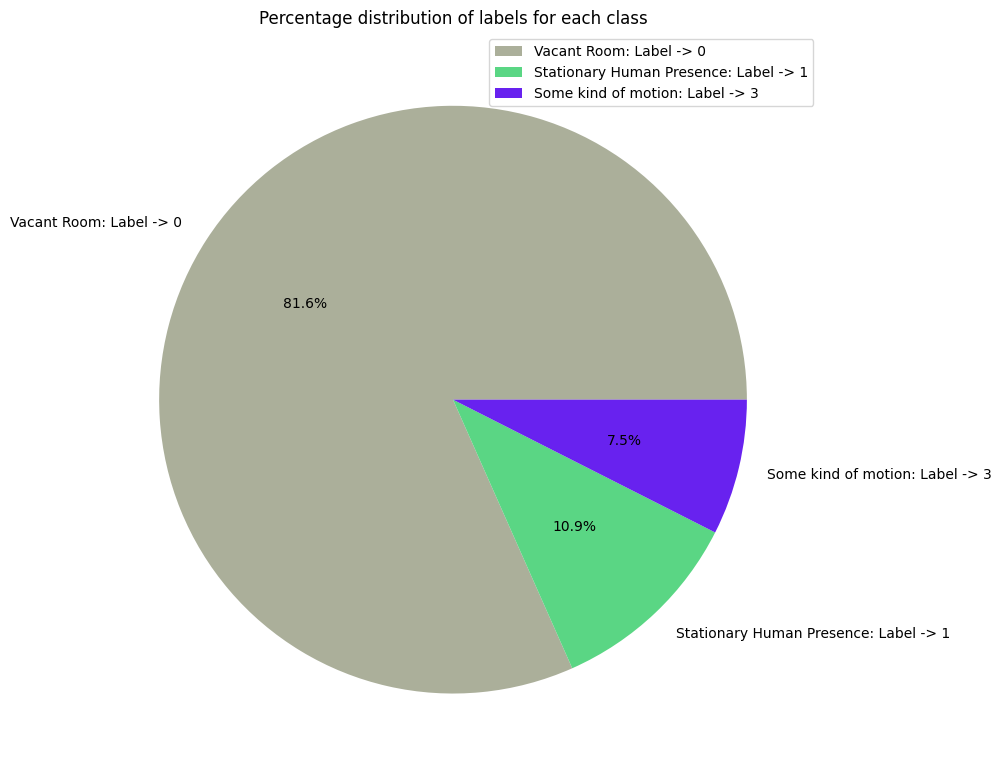

In [93]:
reload_helper()

g = data["Label"].value_counts()
print(g)

g_dict = g.to_dict()
key_mapping = {0: 'Vacant Room: Label -> 0', 1: 'Stationary Human Presence: Label -> 1', 3: 'Some kind of motion: Label -> 3'}
updated_dict = {key_mapping[k]: v for k, v in g_dict.items() if k in key_mapping}

plotter.plot_dict(updated_dict,type="pie", title="Percentage distribution of labels for each class", x_label="", y_label="")

So from the above analysis we can infer that most of the time the room was vacant

Now printing the coorelation matrix

In [22]:
corr_matrix = data.corr().round(3)
corr_matrix.style.background_gradient(cmap="coolwarm", axis=None).format(precision=3)

Plotting the Heat-Map

One Important thing that we found out from looking at the above correlation matrix is that, the reading of a sensor is highly co-related to the reading of the sensors just adjacent to it

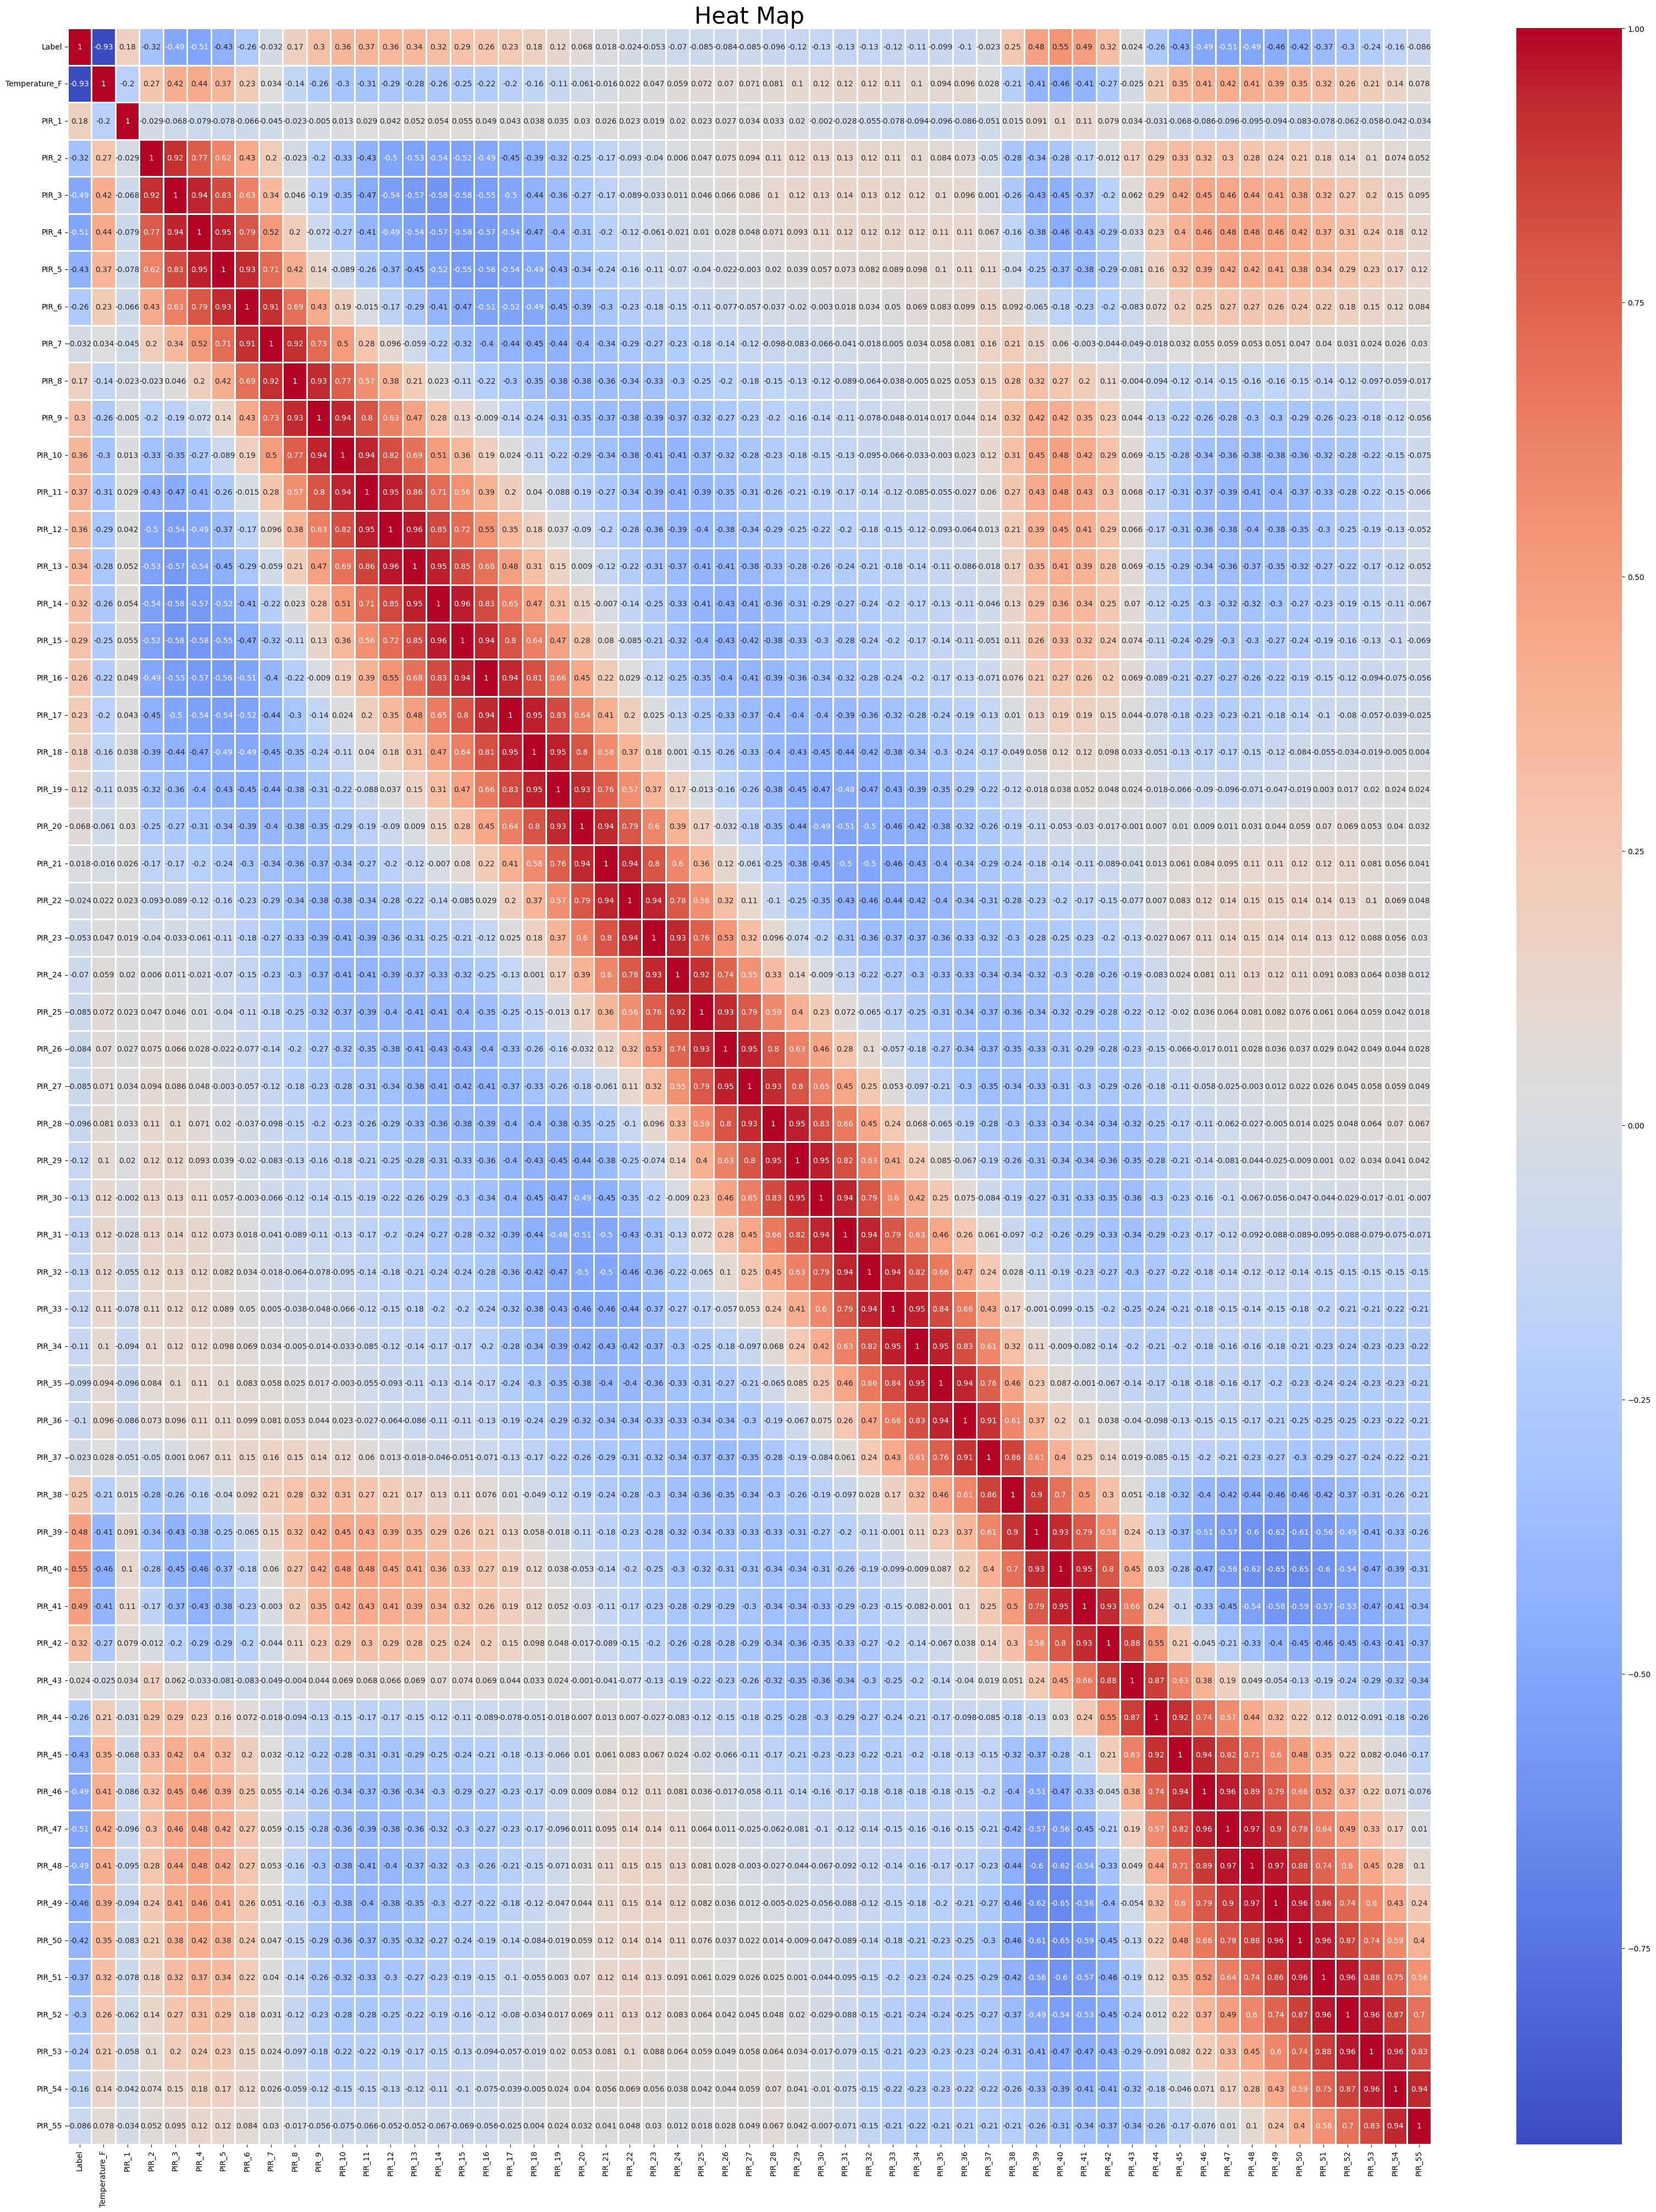

In [23]:
plt.figure(figsize=(40, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidth=1)
plt.title("Heat Map", fontsize = 30)
plt.savefig("Corr_matrix.png", dpi=200)
plt.show()
plt.close()

Highly co-related features <br>

if the features have corelation > 0.8 then we are considering them else not

Now We are getting the highly correlated features <br>
We can see the pattern that we discussed above, the one sensor is highly co-related to the sensor adjacent to it.

Number of Highly Co-related features with window size 0: 158
('Label', 'Temperature_F')
('Temperature_F', 'Label')
('PIR_2', 'PIR_3')
('PIR_3', 'PIR_2')
('PIR_3', 'PIR_4')
('PIR_3', 'PIR_5')
('PIR_4', 'PIR_3')
('PIR_4', 'PIR_5')
('PIR_5', 'PIR_3')
('PIR_5', 'PIR_4')
('PIR_5', 'PIR_6')
('PIR_6', 'PIR_5')
('PIR_6', 'PIR_7')
('PIR_7', 'PIR_6')
('PIR_7', 'PIR_8')
('PIR_8', 'PIR_7')
('PIR_8', 'PIR_9')
('PIR_9', 'PIR_8')
('PIR_9', 'PIR_10')
('PIR_9', 'PIR_11')
('PIR_10', 'PIR_9')
('PIR_10', 'PIR_11')
('PIR_10', 'PIR_12')
('PIR_11', 'PIR_9')
('PIR_11', 'PIR_10')
('PIR_11', 'PIR_12')
('PIR_11', 'PIR_13')
('PIR_12', 'PIR_10')
('PIR_12', 'PIR_11')
('PIR_12', 'PIR_13')
('PIR_12', 'PIR_14')
('PIR_13', 'PIR_11')
('PIR_13', 'PIR_12')
('PIR_13', 'PIR_14')
('PIR_13', 'PIR_15')
('PIR_14', 'PIR_12')
('PIR_14', 'PIR_13')
('PIR_14', 'PIR_15')
('PIR_14', 'PIR_16')
('PIR_15', 'PIR_13')
('PIR_15', 'PIR_14')
('PIR_15', 'PIR_16')
('PIR_16', 'PIR_14')
('PIR_16', 'PIR_15')
('PIR_16', 'PIR_17')
('PIR_16', 'PIR_18

/home/ashutoshr/Deep-Learning/Assignments/Project/Helper.py:155: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


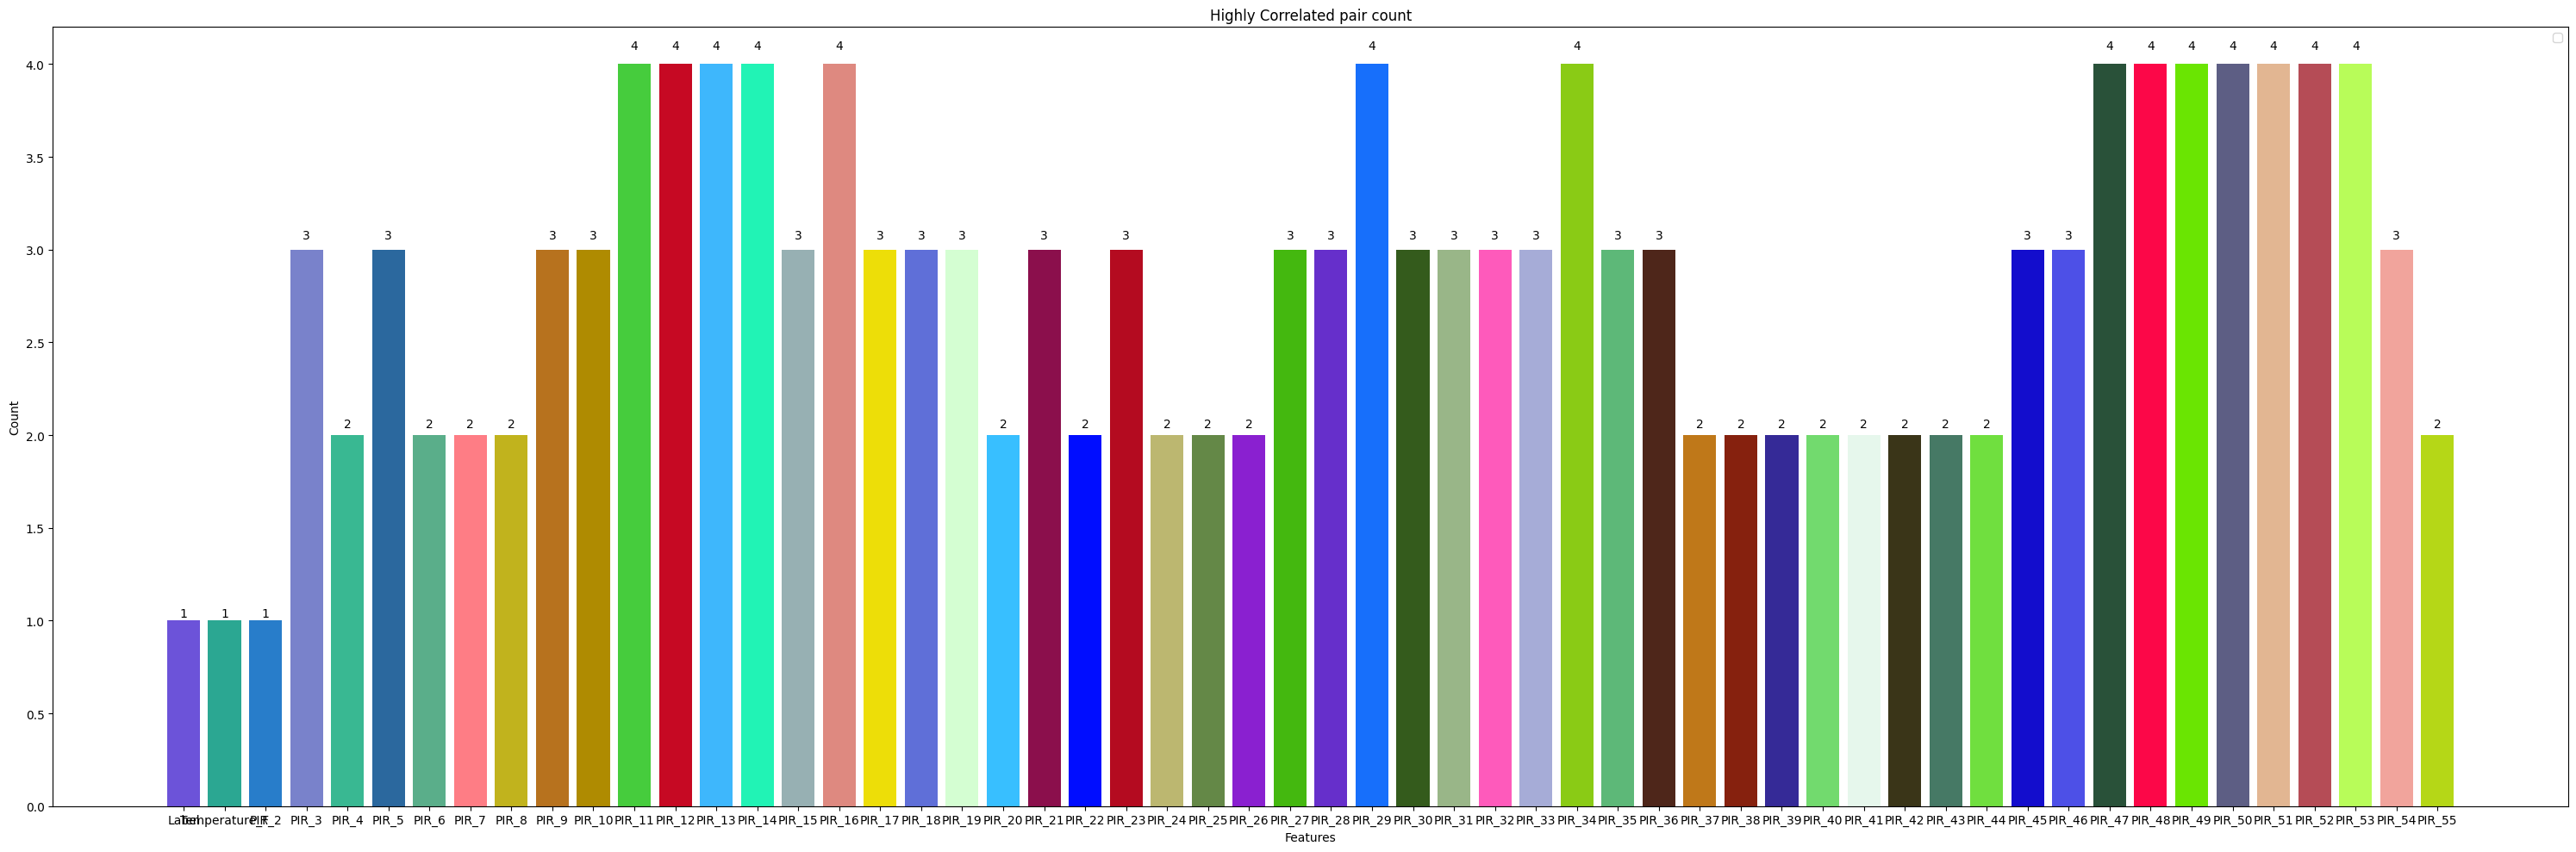

In [24]:
reload_helper()

high_corr_pairs = processor.get_correlated_features(corr_matrix,Threshold=0.8, print_it=True)
plotter.show_plot_for_corr_pairs(high_corr_pairs,fig_dimy=10,fig_dimx=30, title="Highly Correlated pair count", x_label="Features", y_label="Count")

So, Now dropping the features based on the above data will not be fruitfull <br>
So we decided to look for co-related by neglecting 1 adjacent sensor

Highly correlated features with window size = 1 <br>
Meaning leave 1 adjancent sensor and check with others

Number of Highly Co-related features with window size 1: 50
('PIR_3', 'PIR_5')
('PIR_5', 'PIR_3')
('PIR_9', 'PIR_11')
('PIR_10', 'PIR_12')
('PIR_11', 'PIR_9')
('PIR_11', 'PIR_13')
('PIR_12', 'PIR_10')
('PIR_12', 'PIR_14')
('PIR_13', 'PIR_11')
('PIR_13', 'PIR_15')
('PIR_14', 'PIR_12')
('PIR_14', 'PIR_16')
('PIR_15', 'PIR_13')
('PIR_16', 'PIR_14')
('PIR_16', 'PIR_18')
('PIR_17', 'PIR_19')
('PIR_18', 'PIR_16')
('PIR_19', 'PIR_17')
('PIR_21', 'PIR_23')
('PIR_23', 'PIR_21')
('PIR_27', 'PIR_29')
('PIR_28', 'PIR_30')
('PIR_29', 'PIR_27')
('PIR_29', 'PIR_31')
('PIR_30', 'PIR_28')
('PIR_31', 'PIR_29')
('PIR_32', 'PIR_34')
('PIR_33', 'PIR_35')
('PIR_34', 'PIR_32')
('PIR_34', 'PIR_36')
('PIR_35', 'PIR_33')
('PIR_36', 'PIR_34')
('PIR_45', 'PIR_47')
('PIR_46', 'PIR_48')
('PIR_47', 'PIR_45')
('PIR_47', 'PIR_49')
('PIR_48', 'PIR_46')
('PIR_48', 'PIR_50')
('PIR_49', 'PIR_47')
('PIR_49', 'PIR_51')
('PIR_50', 'PIR_48')
('PIR_50', 'PIR_52')
('PIR_51', 'PIR_49')
('PIR_51', 'PIR_53')
('PIR_52', 'PIR_50')
(

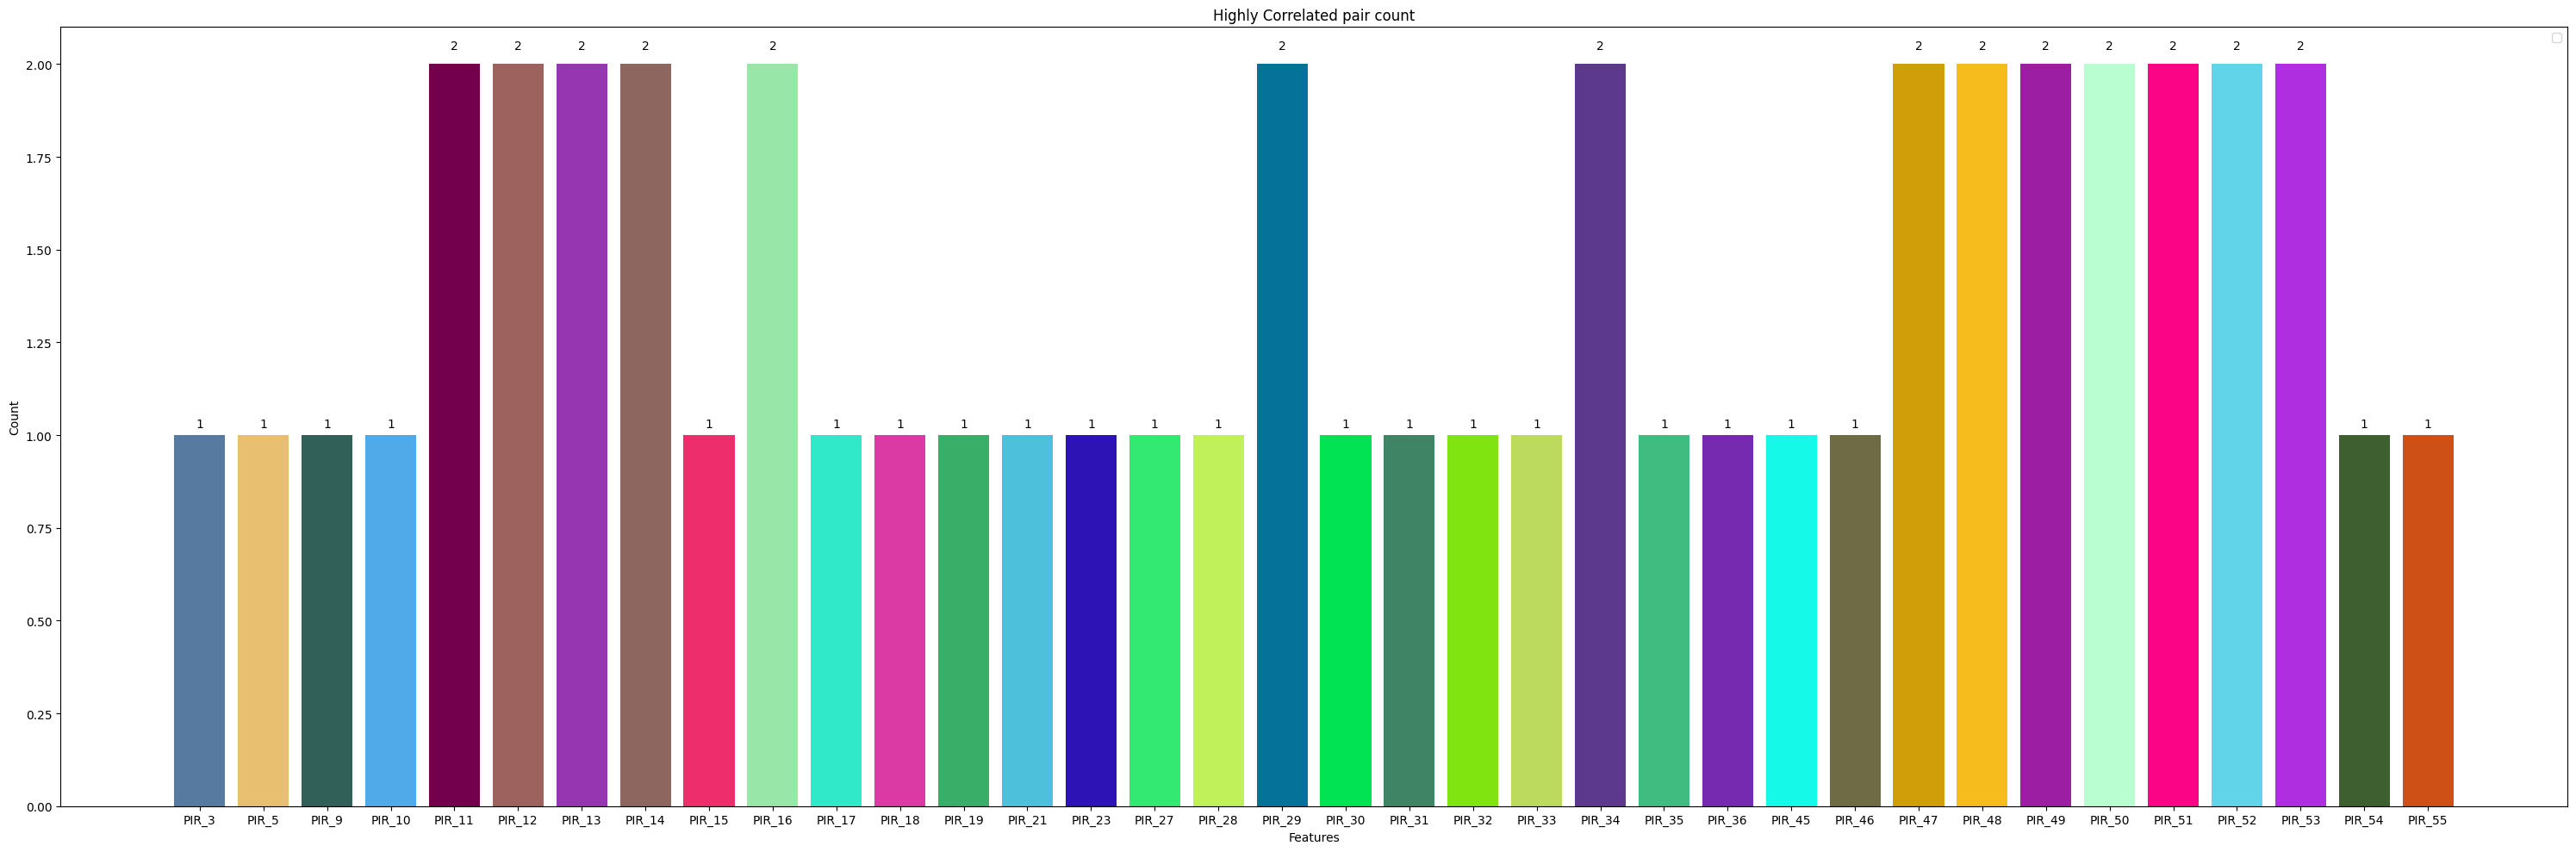

In [25]:
high_corr_pairs_window_1 = processor.get_correlated_features(corr_matrix,window=1,Threshold=0.8, print_it=True)
plotter.show_plot_for_corr_pairs(high_corr_pairs_window_1,fig_dimy=10,fig_dimx=30, title="Highly Correlated pair count", x_label="Features", y_label="Count")

Now repeating the process with window size = 2 <br>

This time we did not get any features

In [26]:
high_corr_pairs_window_2 = processor.get_correlated_features(corr_matrix, window=2,Threshold=0.8, print_it=True)

Number of Highly Co-related features with window size 2: 0


From the above visualization we did not find any useful information <br>

So now we are getting all the features which are co-related to the label <br>

Here are considering the features which have a corelation of 0.45 or greater with respect to label

Highly Corelated features with respect to Label 

1. Label                   : 1.0
2. Temperature_F           : -0.929
3. PIR_3                   : -0.488
4. PIR_4                   : -0.507
5. PIR_39                  : 0.479
6. PIR_40                  : 0.545
7. PIR_41                  : 0.49
8. PIR_46                  : -0.495
9. PIR_47                  : -0.506
10. PIR_48                  : -0.495
11. PIR_49                  : -0.462


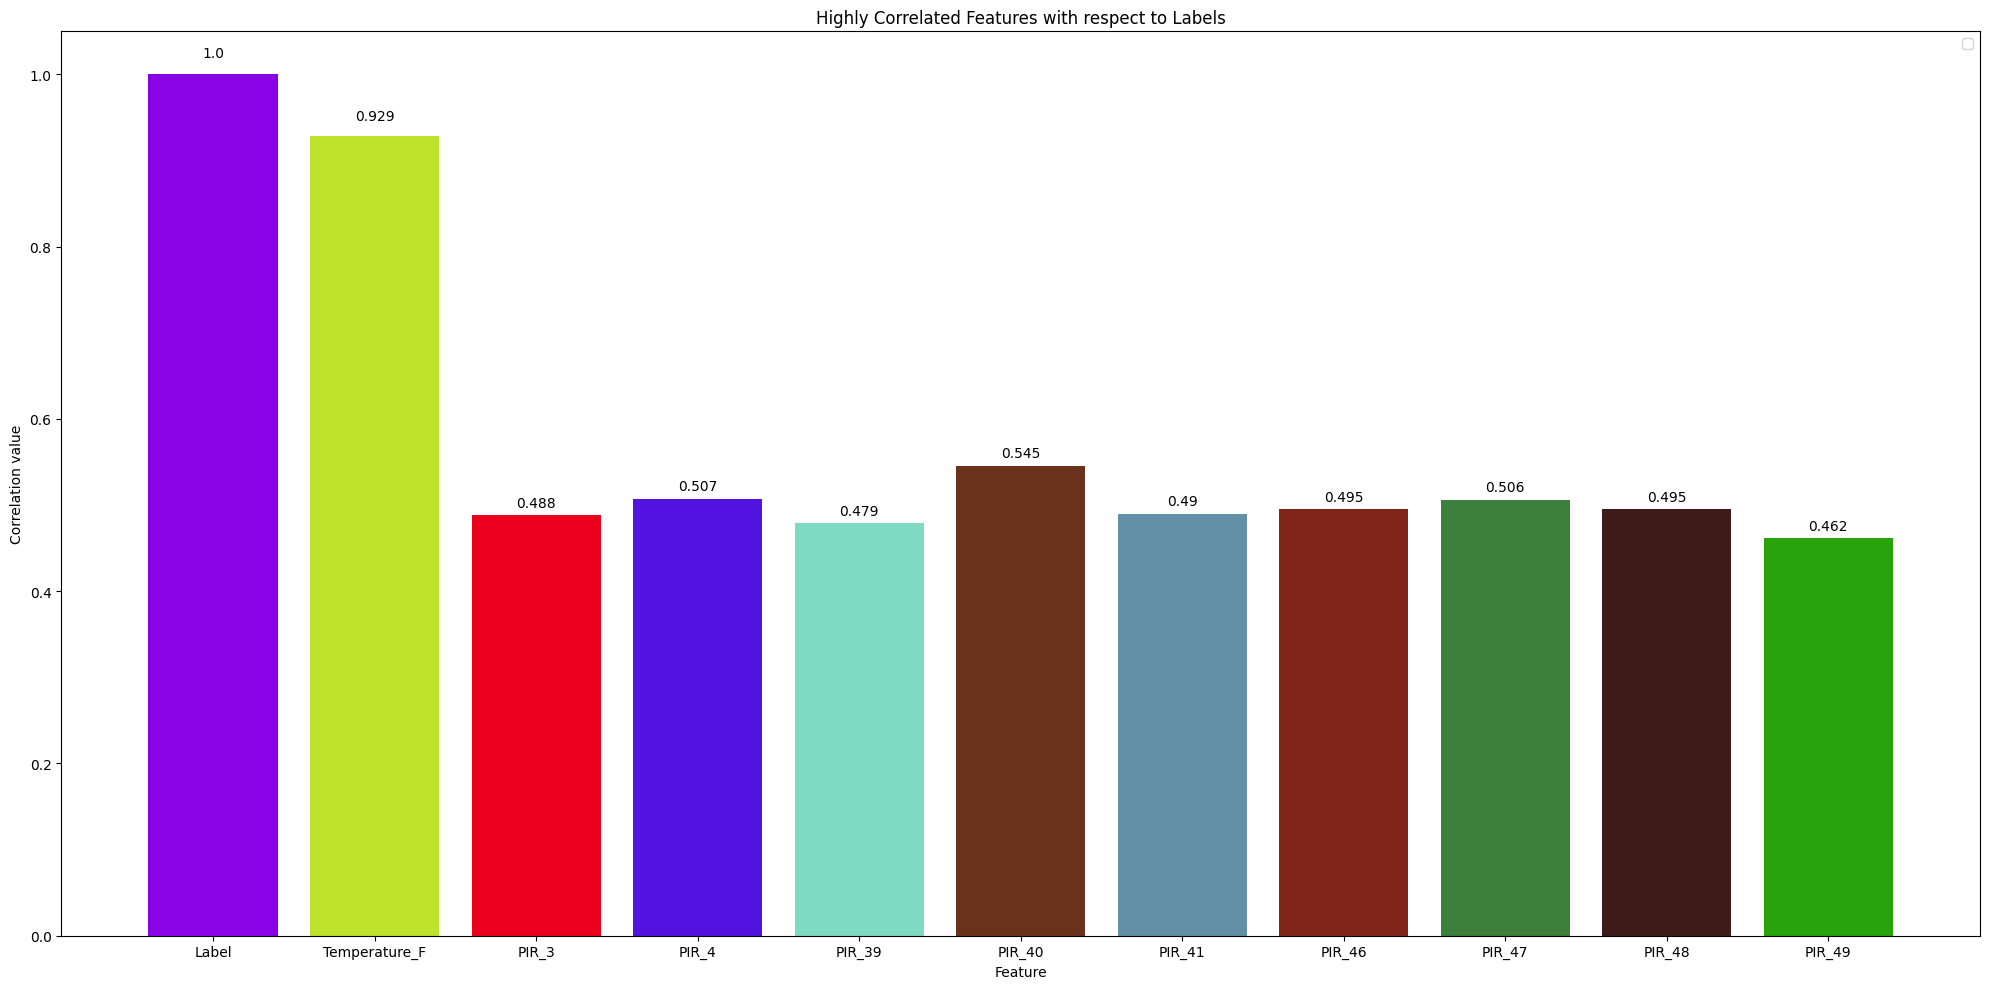

In [27]:
strong_corr_features = corr_matrix["Label"][(corr_matrix["Label"] >= 0.45) | (corr_matrix["Label"] <= -0.45)].index.to_list()
print("Highly Corelated features with respect to Label \n")
strong_corr_features_dict = {}
for i, feature in enumerate(strong_corr_features, start=1):
    corr_value = corr_matrix.loc[feature, "Label"]
    print(f'{i}. {feature:<24}: {corr_value}')
    strong_corr_features_dict[feature] = abs(corr_value)

plotter.plot_dict(strong_corr_features_dict,fig_dimx=20, title="Highly Correlated Features with respect to Labels", x_label="Feature", y_label="Correlation value")


We infered that the feature "Temperature_F" is very higly co-related to "Label" <br>

So we decided to keep "Temperture_F" in our dataset

Now we will be using Variance Threshold for doing feature selection

Feature Selection using Variance Threshold

Separating labels and data

In [28]:
reload_helper()
labels, data_without_label = processor.separate_label(data=data)

In [29]:
selector = VarianceThreshold(threshold=0.001)
selected_features = selector.fit_transform(data_without_label)

selected_features_names = data_without_label.columns[selector.get_support()]

print(f"Number of features selected: {len(selected_features_names)}")
print(f"Selected Features: {selected_features_names}")

Number of features selected: 56
Selected Features: Index(['Temperature_F', 'PIR_1', 'PIR_2', 'PIR_3', 'PIR_4', 'PIR_5', 'PIR_6',
       'PIR_7', 'PIR_8', 'PIR_9', 'PIR_10', 'PIR_11', 'PIR_12', 'PIR_13',
       'PIR_14', 'PIR_15', 'PIR_16', 'PIR_17', 'PIR_18', 'PIR_19', 'PIR_20',
       'PIR_21', 'PIR_22', 'PIR_23', 'PIR_24', 'PIR_25', 'PIR_26', 'PIR_27',
       'PIR_28', 'PIR_29', 'PIR_30', 'PIR_31', 'PIR_32', 'PIR_33', 'PIR_34',
       'PIR_35', 'PIR_36', 'PIR_37', 'PIR_38', 'PIR_39', 'PIR_40', 'PIR_41',
       'PIR_42', 'PIR_43', 'PIR_44', 'PIR_45', 'PIR_46', 'PIR_47', 'PIR_48',
       'PIR_49', 'PIR_50', 'PIR_51', 'PIR_52', 'PIR_53', 'PIR_54', 'PIR_55'],
      dtype='object')


So basically we got back all the features <br>
This means none of the features are constant or quasi-constant across samples

Using Information gain for feature selection

In [30]:
mi_scores = mutual_info_classif(data_without_label, labels)
mi_df = pd.DataFrame({'Feature': data_without_label.columns, 'MI Score': mi_scores})
print(mi_df)

mi_df_sorted = mi_df.sort_values(by='MI Score', ascending=False)

# Select top features (e.g., top 2)
top_features = mi_df_sorted.head(20)['Feature'].tolist()


          Feature  MI Score
0   Temperature_F  0.381221
1           PIR_1  0.107700
2           PIR_2  0.213310
3           PIR_3  0.375142
4           PIR_4  0.410517
5           PIR_5  0.314792
6           PIR_6  0.181734
7           PIR_7  0.083973
8           PIR_8  0.175745
9           PIR_9  0.298508
10         PIR_10  0.355794
11         PIR_11  0.370023
12         PIR_12  0.377058
13         PIR_13  0.358950
14         PIR_14  0.347247
15         PIR_15  0.314004
16         PIR_16  0.289507
17         PIR_17  0.261393
18         PIR_18  0.210905
19         PIR_19  0.164703
20         PIR_20  0.120388
21         PIR_21  0.107015
22         PIR_22  0.120541
23         PIR_23  0.126063
24         PIR_24  0.142102
25         PIR_25  0.154652
26         PIR_26  0.155430
27         PIR_27  0.171983
28         PIR_28  0.172859
29         PIR_29  0.178611
30         PIR_30  0.176857
31         PIR_31  0.165139
32         PIR_32  0.155836
33         PIR_33  0.156769
34         PIR_34  0

So we got the list of the top 20 features using information gain

In [31]:
print("Selected Features:")
print()
for i in top_features:
    print(i)

Selected Features:

PIR_40
PIR_48
PIR_47
PIR_49
PIR_4
PIR_46
PIR_50
Temperature_F
PIR_12
PIR_3
PIR_41
PIR_11
PIR_13
PIR_10
PIR_45
PIR_39
PIR_14
PIR_51
PIR_5
PIR_15


Checking for features with zero standard deviation

In [32]:
reload_helper()
zero_std_cols = processor.features_with_zero_std(data=data_without_label)
print(zero_std_cols)

[]


So we can see that there is no feature which have zero standard deviation

Now Counting the number of unique values of each feature

Unique Value cout for:
1   Temperature_F                 : 6
2   PIR_1                         : 1110
3   PIR_2                         : 1644
4   PIR_3                         : 1771
5   PIR_4                         : 1763
6   PIR_5                         : 1659
7   PIR_6                         : 1373
8   PIR_7                         : 1128
9   PIR_8                         : 1141
10  PIR_9                         : 1296
11  PIR_10                        : 1391
12  PIR_11                        : 1447
13  PIR_12                        : 1452
14  PIR_13                        : 1412
15  PIR_14                        : 1357
16  PIR_15                        : 1260
17  PIR_16                        : 1173
18  PIR_17                        : 1065
19  PIR_18                        : 953
20  PIR_19                        : 865
21  PIR_20                        : 806
22  PIR_21                        : 774
23  PIR_22                        : 773
24  PIR_23                        : 785
25

/home/ashutoshr/Deep-Learning/Assignments/Project/Helper.py:155: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


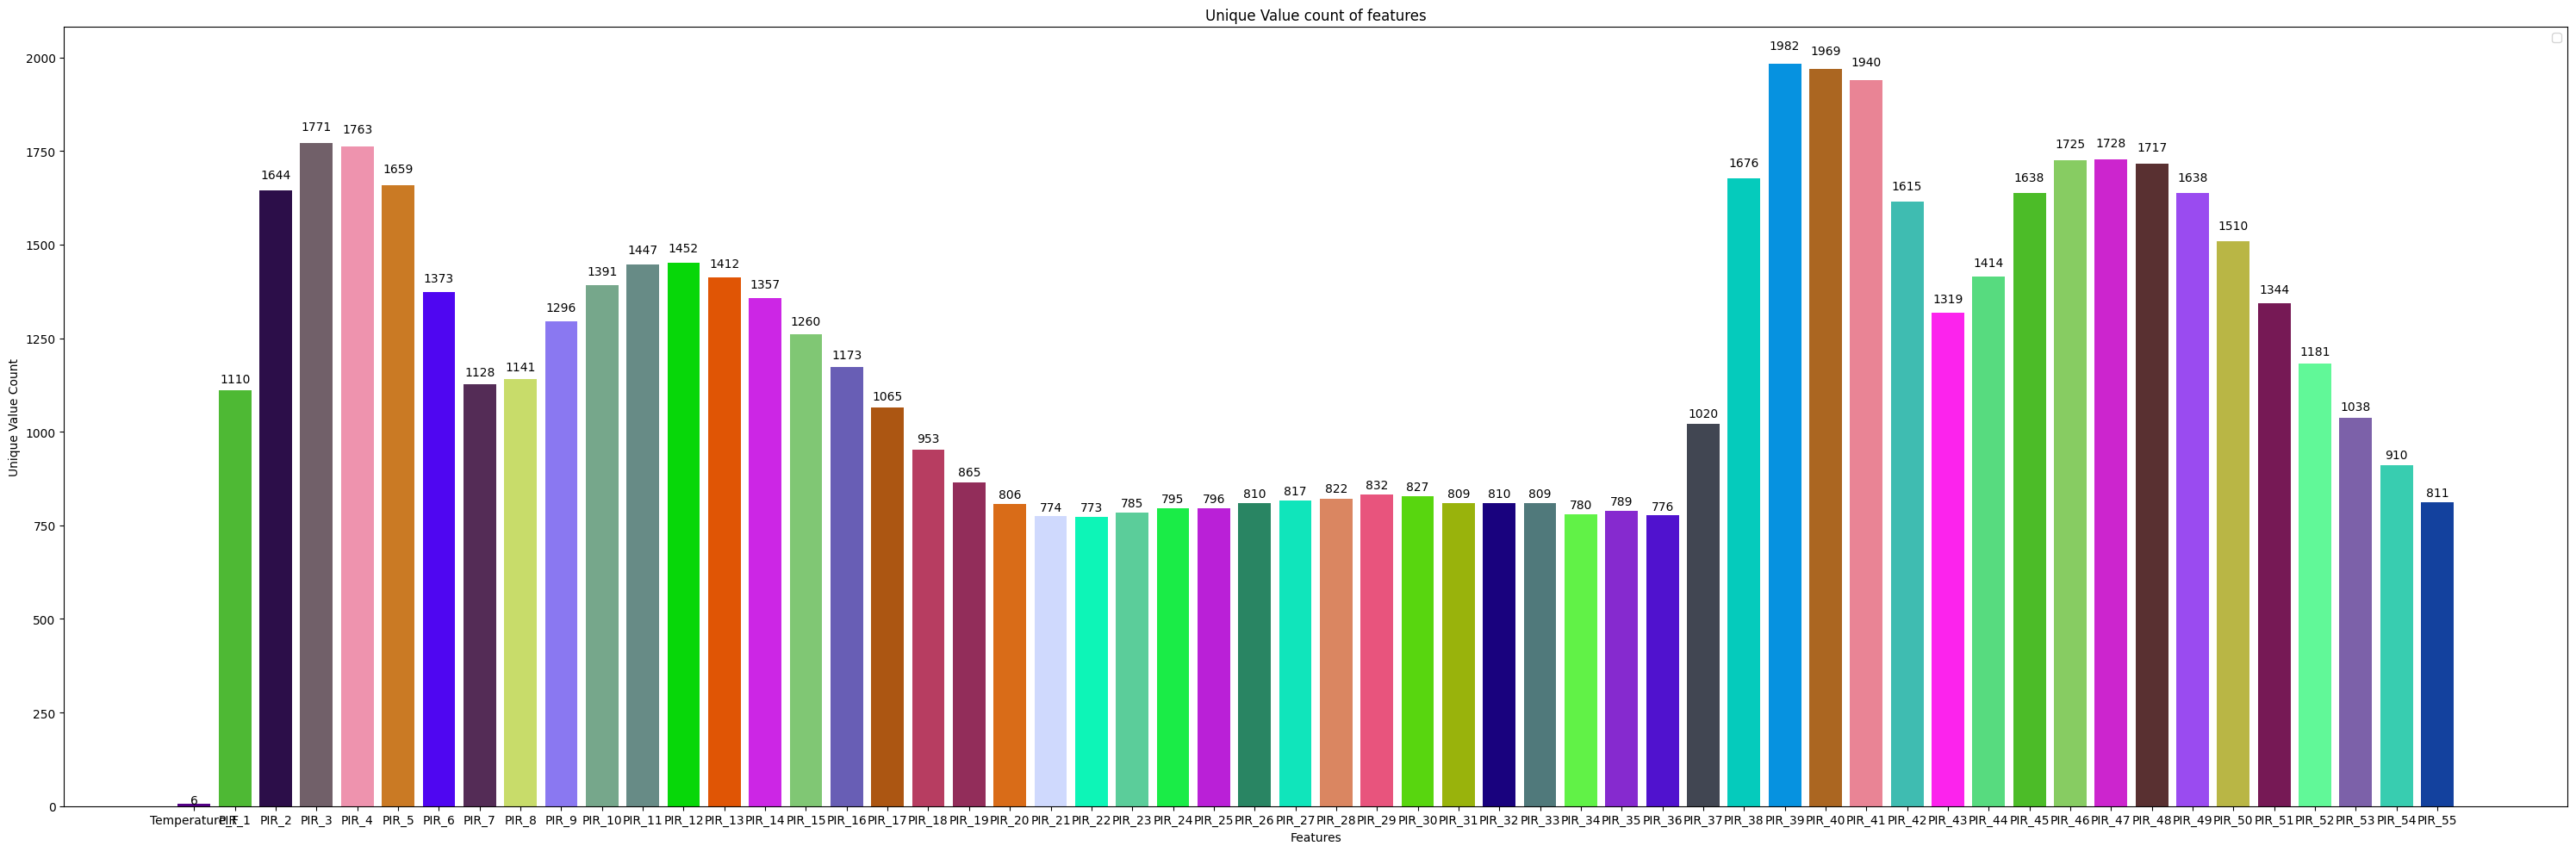

In [33]:
indent = '{:<3} {:<30}: {}'
print("Unique Value cout for:")
unique_dict = {}

for i, cols in enumerate(list(data_without_label.columns), start=1):
    print(indent.format(f'{i}', cols, data_without_label[cols].nunique()))
    unique_dict[cols] = data_without_label[cols].nunique()

plotter.plot_dict(unique_dict, fig_dimx=30, title="Unique Value count of features", x_label="Features", y_label="Unique Value Count")

We cannot infer any useful information from the number of unique counts of all the features

Identifying Outliers <br>

So we are using quantile ranges for identifying outliers

          Feature  Outlier Count  Outlier Percentage
0   Temperature_F            571                7.46
1           PIR_1            195                2.55
2           PIR_2            123                1.61
3           PIR_3            116                1.52
4           PIR_4            122                1.59
5           PIR_5            141                1.84
6           PIR_6            152                1.99
7           PIR_7            171                2.24
8           PIR_8            181                2.37
9           PIR_9            162                2.12
10         PIR_10            149                1.95
11         PIR_11            137                1.79
12         PIR_12            138                1.80
13         PIR_13            138                1.80
14         PIR_14            152                1.99
15         PIR_15            164                2.14
16         PIR_16            179                2.34
17         PIR_17            192              

/home/ashutoshr/Deep-Learning/Assignments/Project/Helper.py:155: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


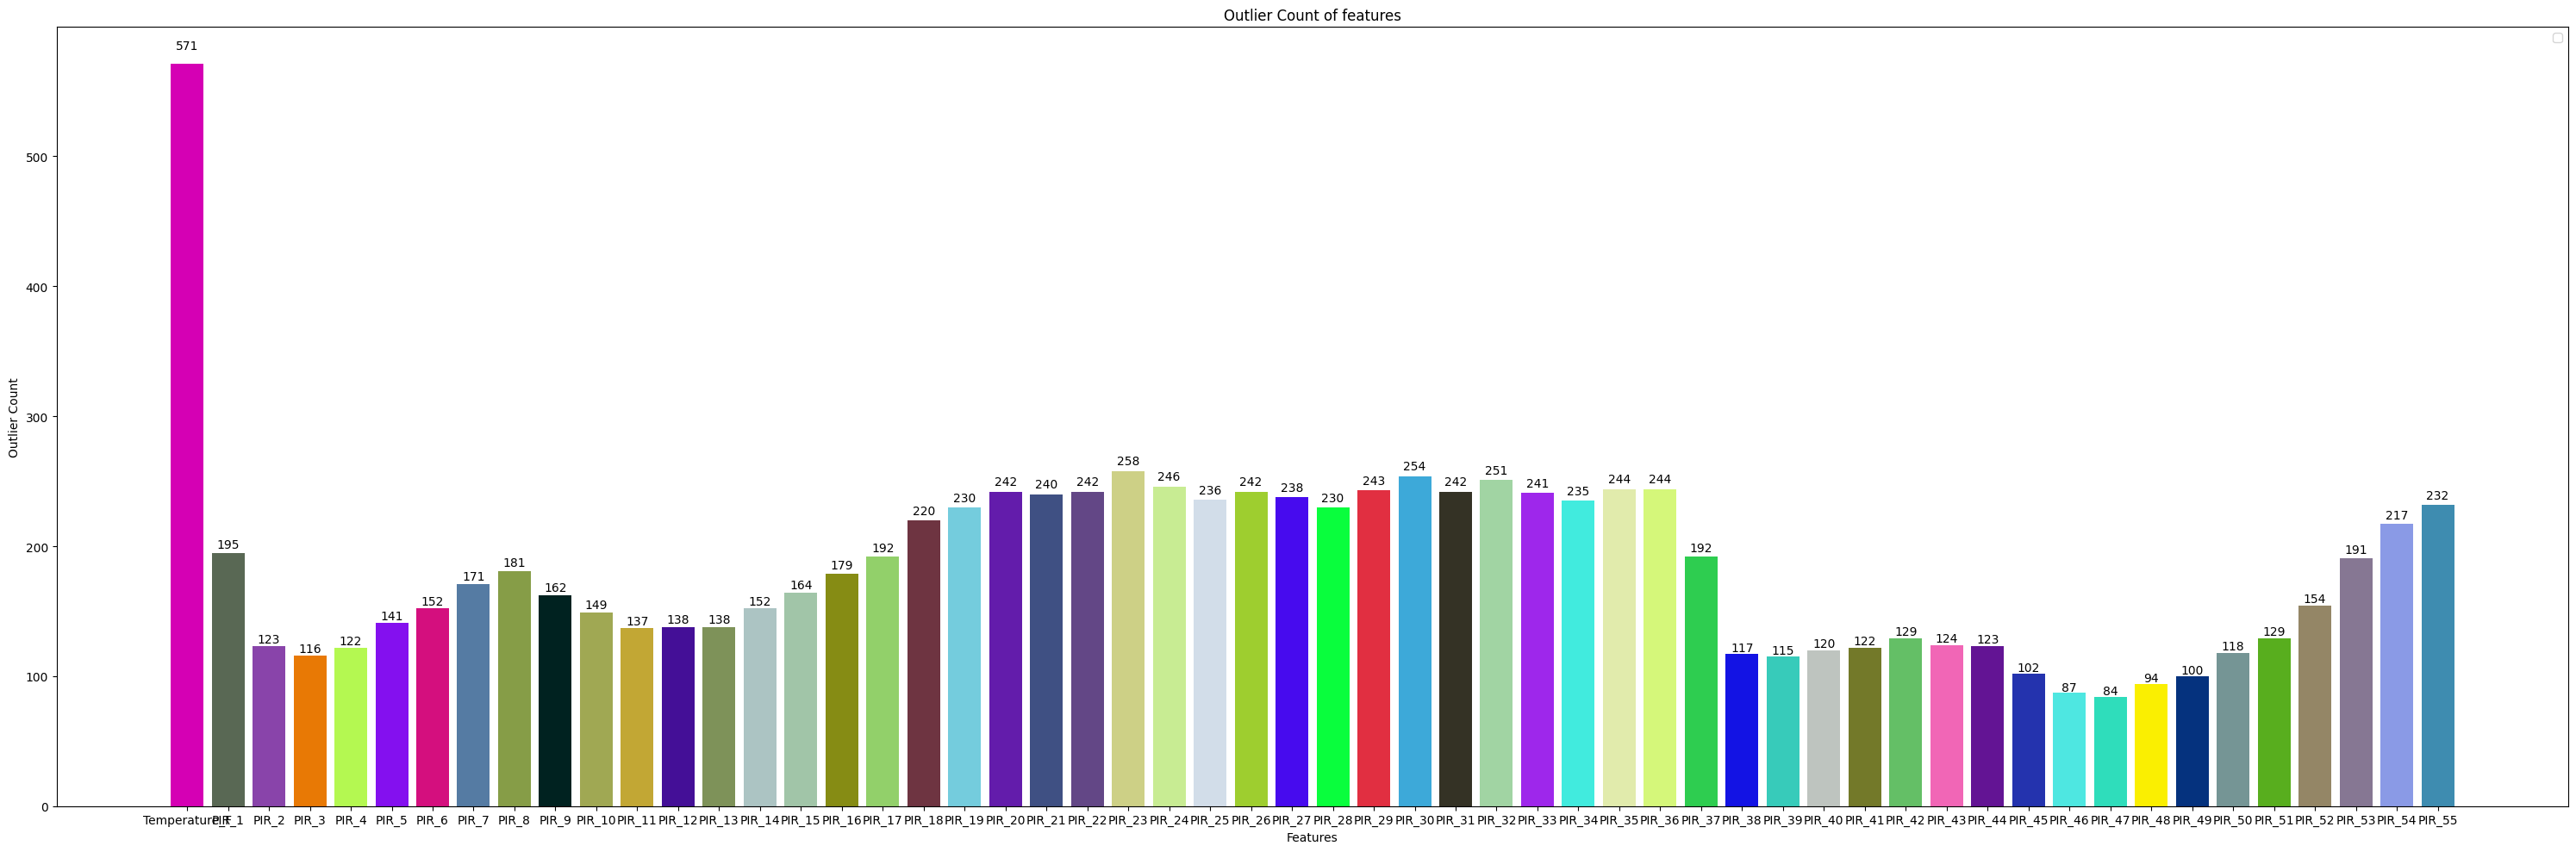

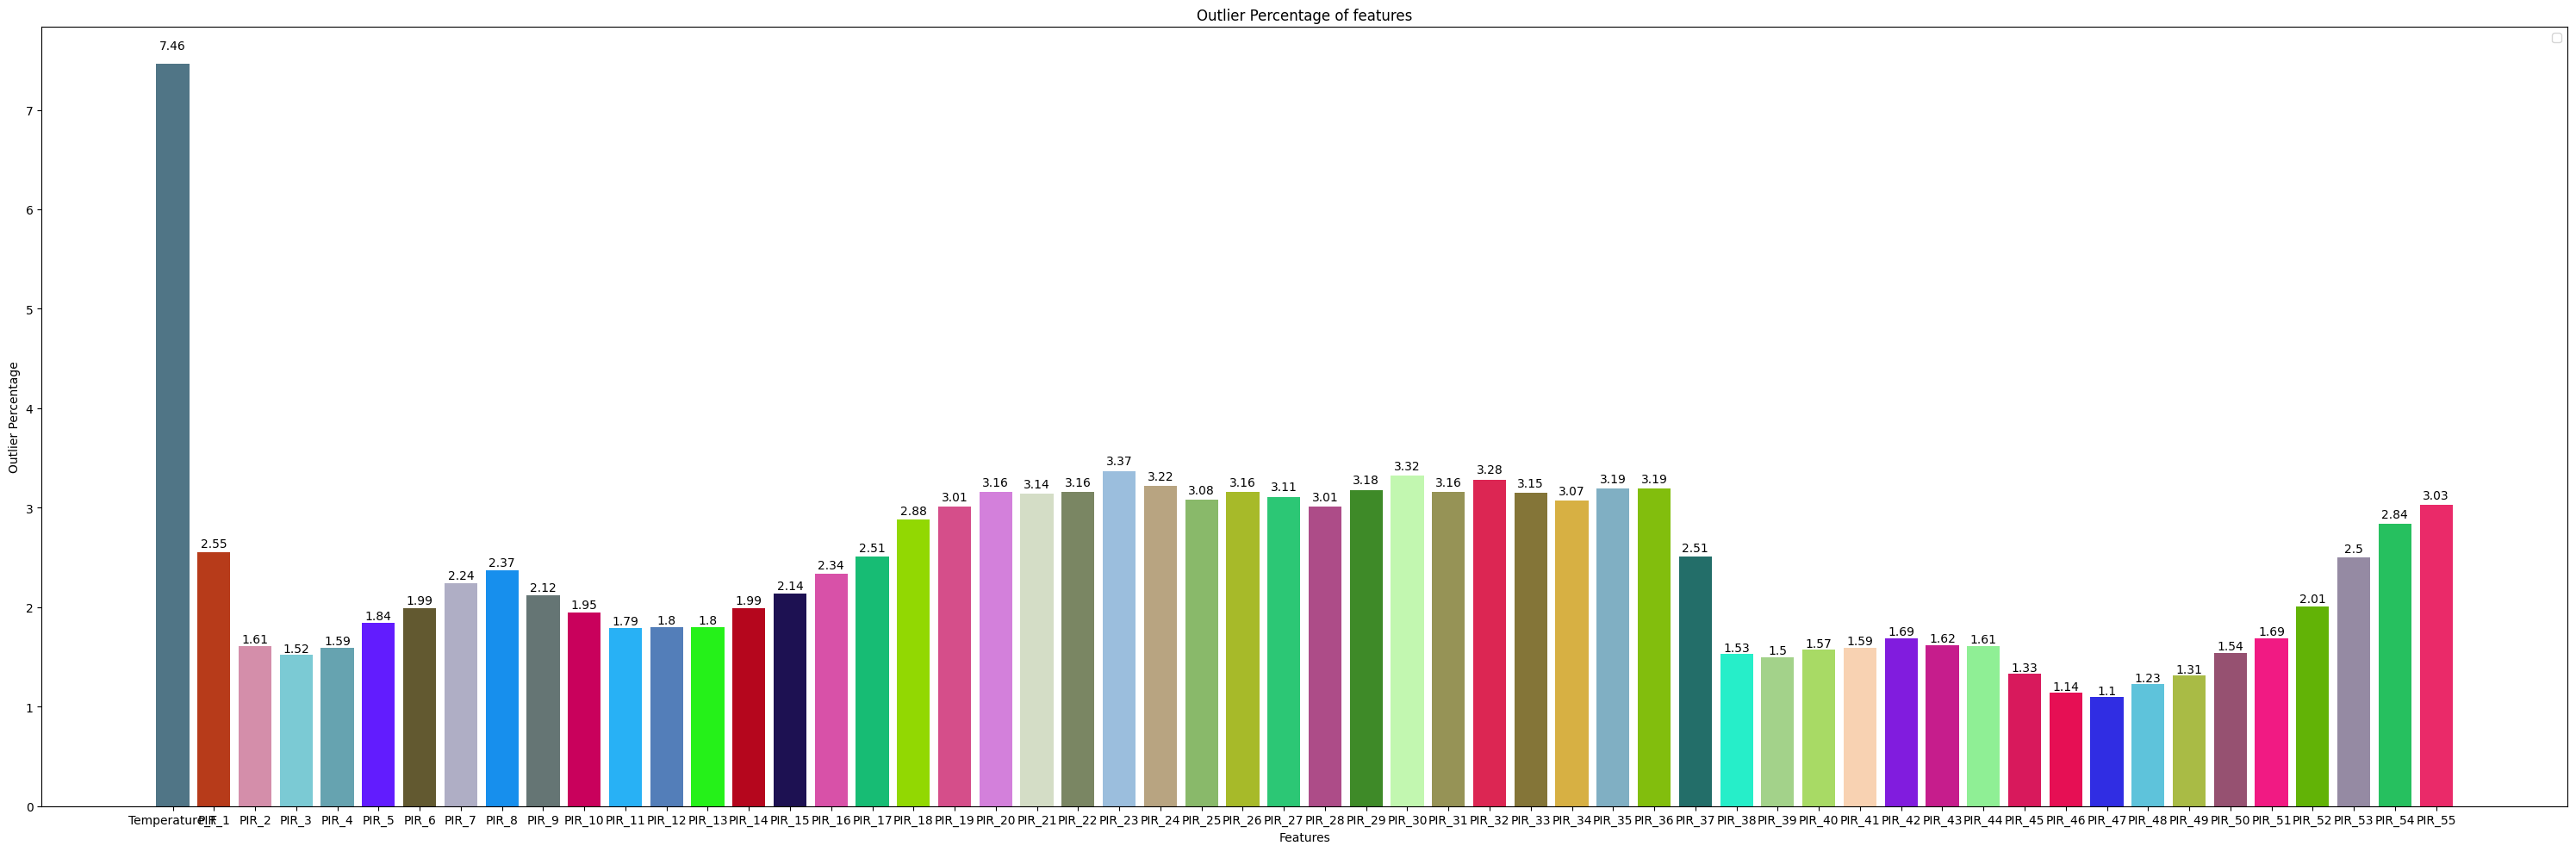

In [34]:
q1 = data_without_label.quantile(0.15)
q3 = data_without_label.quantile(0.85)

inter_quartile_range = q3 - q1
outliers = (data_without_label < (q1 - 1.5 * inter_quartile_range)) | (data_without_label > (q3 + 1.5 * inter_quartile_range))
outlier_count = outliers.sum()

outlier_count_dict = {}
outlier_percentage_dict = {}

outlier_percentage = round(outliers.mean() * 100, 2)
outlier_stat = pd.concat([outlier_count, outlier_percentage], axis = 1)
outlier_stat.columns = ["Outlier Count", "Outlier Percentage"]
outlier_stat.index.name="Feature"
outlier_stat.reset_index(inplace=True)
print(outlier_stat)
print(type(outlier_stat))

for i in range(len(outlier_stat)):
    outlier_count_dict[outlier_stat.iloc[i,0]] = outlier_stat.iloc[i, 1]
    outlier_percentage_dict[outlier_stat.iloc[i,0]] = outlier_stat.iloc[i, 2]

plotter.plot_dict(outlier_count_dict, fig_dimx=30,title="Outlier Count of features", x_label="Features", y_label="Outlier Count")
plotter.plot_dict(outlier_percentage_dict,fig_dimx=30,title="Outlier Percentage of features", x_label="Features", y_label="Outlier Percentage")


we found that the "Temperature_F" feature has the highest number of outliers

In [35]:
print("----------------Top Charts---------------\n")
sorted_outliers = outlier_stat.sort_values(by="Outlier Count", ascending=False)

print("Top 5 Features with the highest number of outliers")
print(sorted_outliers.head(5))

print()

print("Top 5 Features with the lowest number of outliers")
print(sorted_outliers.tail(5))

----------------Top Charts---------------

Top 5 Features with the highest number of outliers
          Feature  Outlier Count  Outlier Percentage
0   Temperature_F            571                7.46
23         PIR_23            258                3.37
30         PIR_30            254                3.32
32         PIR_32            251                3.28
24         PIR_24            246                3.22

Top 5 Features with the lowest number of outliers
   Feature  Outlier Count  Outlier Percentage
45  PIR_45            102                1.33
49  PIR_49            100                1.31
48  PIR_48             94                1.23
46  PIR_46             87                1.14
47  PIR_47             84                1.10


/home/ashutoshr/Deep-Learning/Assignments/Project/Helper.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = self.sns.barplot(


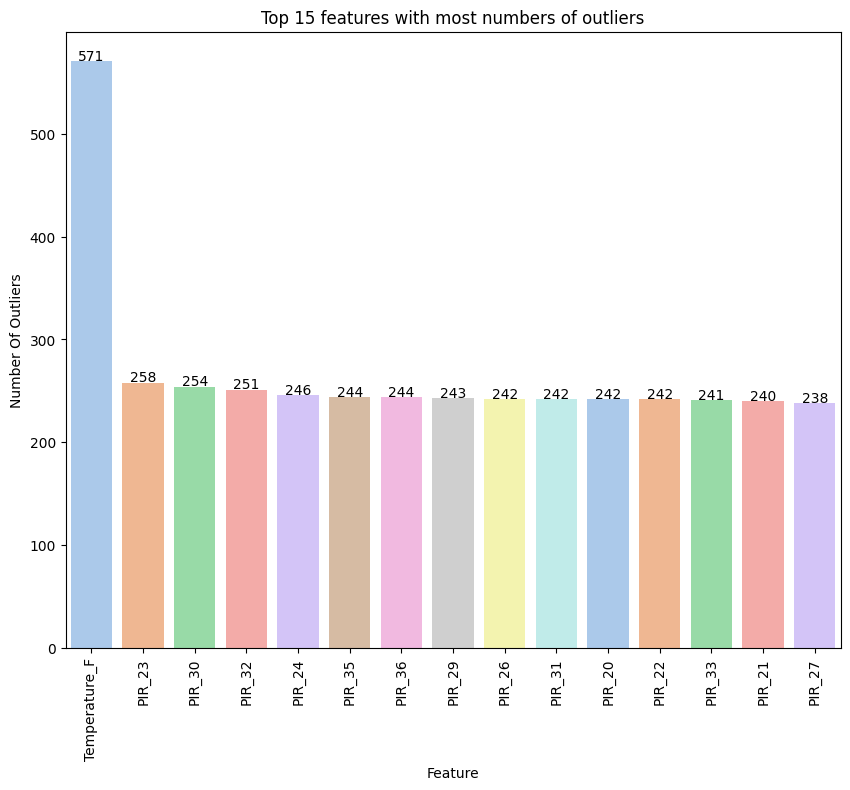

In [36]:
plotter.bar_plot(data=sorted_outliers.head(15), x_feature_name="Feature", y_feature_name="Outlier Count", fig_dimx=10, fig_dimy=8,title="Top 15 features with most numbers of outliers", x_label="Feature", y_label="Number Of Outliers")

Now doing manual label selection

So far we did lot of data visualization and now for doing Manual feature selection <br>

We are Taking the 10 labels which are highly co-realted with the feature "Label" <br>
We are also taking the top 20 features which have the highest information gain <br>

Now we are also taking care that a label should not be added twice <br>

Finally we got 20 features as the ouput for the manual dataset

In [37]:
manual_feature_list = []

# Adding highly correlated features with respect to label
strong_corr_features_list = list(strong_corr_features_dict.keys())
strong_corr_features_list.remove("Label")

for lbl in strong_corr_features_list:
    manual_feature_list.append(lbl)

# Adding features from information gain
for lbl in top_features:
    if manual_feature_list.__contains__(lbl):
        continue
    else:
        manual_feature_list.append(lbl)

for i in  manual_feature_list:
    print(i)

Temperature_F
PIR_3
PIR_4
PIR_39
PIR_40
PIR_41
PIR_46
PIR_47
PIR_48
PIR_49
PIR_50
PIR_12
PIR_11
PIR_13
PIR_10
PIR_45
PIR_14
PIR_51
PIR_5
PIR_15


Now In Order to compare that the features we selected are good enough or not, we will be creating 2 Additional Datasets  <br>
1. PCA dataset -> 20 Features
2. SmartFeatureSelection -> Feature engine library (25 Features)

Scaling the data

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_without_label)

Applying PCA

In [39]:
reload_helper()

from sklearn.decomposition import IncrementalPCA

size = 20
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(scaled_features) // 500):
    ipca.partial_fit(batch)

print(f"Information Retained:  {sum(ipca.explained_variance_ratio_):.2%}")


Information Retained:  99.10%


In [40]:
transformed_features = ipca.transform(scaled_features)
pca_transformed_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])

pca_transformed_data

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     2.327982 -0.122215  0.498579 -0.034308 -0.273753 -0.337466 -0.206041   
1     2.725461 -0.105468  0.345163 -0.098064 -0.574644  0.883227  0.170550   
2     2.588787 -0.177600  0.191362  0.071078 -0.143177 -0.180320 -0.242265   
3     2.668134 -0.059789  0.226421  0.490683 -0.806395 -0.977650 -0.256186   
4     2.379718 -0.044429  0.360539  0.211552 -0.401447 -0.141140 -0.044682   
...        ...       ...       ...       ...       ...       ...       ...   
7646 -2.555851  0.512443 -0.175392 -0.758231  0.696220  1.134146  0.132342   
7647 -2.165526 -0.173144 -0.804488  0.015192  1.021496 -0.511323 -0.440578   
7648 -2.065885 -0.497506 -0.465400  1.025150  0.192149 -0.993593  0.036717   
7649 -2.263192  0.315585 -0.611268 -1.295628  0.416219  0.553204 -0.269183   
7650 -2.589783 -0.139712 -0.670140 -0.048187  0.428676 -0.299602 -0.084649   

           PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0    -0.180135 -0.093733 -0.292535 -0.273872  0.425621  0.233308  0.002020   
1     0.042192 -0.706008  0.061528  0.134540  0.319217 -0.013533  0.452025   
2    -0.301640 -0.324299 -0.309840  0.371694  0.097813  0.182773  0.229489   
3    -0.699348  0.025497 -0.417822 -0.256902  0.414283  0.635188  0.218419   
4     0.151308  0.124676 -0.450697 -0.289758  0.355141  0.227183  0.791835   
...        ...       ...       ...       ...       ...       ...       ...   
7646  0.894224 -0.051251  0.197385 -0.284573  0.153532 -0.254875  0.212762   
7647 -0.067373  0.518732 -0.394420 -0.033779 -0.103360  0.203440 -0.403098   
7648 -0.695420  0.458000 -0.466108  0.038684 -0.025037  0.346327 -0.195598   
7649  0.305008 -0.316085  0.136785  0.278612 -0.096207 -0.008623 -0.469249   
7650  0.011640  0.111996 -0.234872  0.274164 -0.002900 -0.049467 -0.216426   

          PC15      PC16      PC17      PC18      PC19      PC20  
0     0.531664 -0.083541  0.046176 -0.065542  0.060569  0.190964  
1     0.379060 -0.059853  0.080011  0.056364  0.126360 -0.121984  
2     0.237658 -0.049404 -0.058472  0.024080  0.193050  0.114891  
3    -0.069191 -0.434932  0.259575 -0.086027  0.161460  0.020218  
4    -0.002876 -0.306165  0.217228 -0.103884 -0.229773 -0.007194  
...        ...       ...       ...       ...       ...       ...  
7646 -0.029935 -0.079760 -0.055169 -0.090835 -0.175406  0.145168  
7647  0.146082  0.339879 -0.123145  0.367169  0.129731 -0.181070  
7648 -0.210726 -0.554632  0.263712  0.230687  0.227731  0.121315  
7649  0.025314  0.147551  0.064841 -0.107632  0.077935  0.002429  
7650 -0.235482 -0.109004 -0.114332  0.229576 -0.058860  0.147531  

[7651 rows x 20 columns]

Applying Feature Engine for Feature Selection

Drop Correlated Features

In [41]:
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection

corr_feature_engine = DropCorrelatedFeatures(threshold=0.8)
corr_feature_engine.fit_transform(data_without_label)
feature_engine_labels = corr_feature_engine.get_feature_names_out()

print(f"Number of Feature Selected by Dropping CorrelatedFeatures: {len(feature_engine_labels)}")

for i in feature_engine_labels:
    print(i)

Number of Feature Selected by Dropping CorrelatedFeatures: 25
Temperature_F
PIR_1
PIR_2
PIR_4
PIR_6
PIR_8
PIR_10
PIR_13
PIR_16
PIR_19
PIR_21
PIR_24
PIR_26
PIR_28
PIR_31
PIR_33
PIR_36
PIR_38
PIR_40
PIR_42
PIR_44
PIR_46
PIR_49
PIR_52
PIR_55


Doing Smart Correlation Selection

In [42]:
smart_feature_engine = SmartCorrelatedSelection(threshold=0.8)
smart_feature_engine.fit_transform(data_without_label)
smart_feature_labels = smart_feature_engine.get_feature_names_out()

print(f"Number of Feature Selected by SmartCorrelatedSelection: {len(smart_feature_labels)}")

for i in smart_feature_labels:
    print(i)

Number of Feature Selected by SmartCorrelatedSelection: 25
Temperature_F
PIR_1
PIR_2
PIR_4
PIR_6
PIR_8
PIR_10
PIR_13
PIR_16
PIR_19
PIR_21
PIR_24
PIR_26
PIR_28
PIR_31
PIR_33
PIR_36
PIR_38
PIR_40
PIR_42
PIR_44
PIR_46
PIR_49
PIR_52
PIR_55


We can see that the labels selected by SmartCorrlatedFeatures is similar to DropCorrelatedFeatures

Now Creating Dataset

So as we are using LSTM so in order to use it accross all datasets we need to drop the last feature from the above feature selection

In [43]:
smart_feature_labels = smart_feature_labels[:-1]

print(f"Number of features selected by smart feature selection: {len(smart_feature_labels)}")

for i in smart_feature_labels:
    print(i)

Number of features selected by smart feature selection: 24
Temperature_F
PIR_1
PIR_2
PIR_4
PIR_6
PIR_8
PIR_10
PIR_13
PIR_16
PIR_19
PIR_21
PIR_24
PIR_26
PIR_28
PIR_31
PIR_33
PIR_36
PIR_38
PIR_40
PIR_42
PIR_44
PIR_46
PIR_49
PIR_52


In [44]:
reload_helper()
manual_dataset = processor.create_dataset(manual_feature_list, data_without_label,False)
feature_engine_dataset = processor.create_dataset(smart_feature_labels, data_without_label, False)

print(manual_dataset)

      Temperature_F  PIR_3  PIR_4  PIR_39  PIR_40  PIR_41  PIR_46  PIR_47  \
0                86  11156  11170    9308    9061    9299   11178   11197   
1                86  11299  11238    9236    9193    9609   11122   11145   
2                86  11197  11242    9368    9135    9287   11168   11204   
3                86  10822  11133    9603    9182    9125   11116   11273   
4                86  11104  11234    9399    9198    9422   11006   11257   
...             ...    ...    ...     ...     ...     ...     ...     ...   
7646             88  11989  11891    8416    8328    8861   11873   11947   
7647             88  11796  12000    8730    8290    8453   11785   11948   
7648             88  11555  11860    8976    8357    8470   11690   11815   
7649             88  12022  11957    8474    8170    8715   11895   11989   
7650             88  11897  11990    8673    8362    8578   11858   11901   

      PIR_48  PIR_49  PIR_50  PIR_12  PIR_11  PIR_13  PIR_10  PIR_45  PIR_1

In [45]:
print(feature_engine_dataset)

      Temperature_F  PIR_1  PIR_2  PIR_4  PIR_6  PIR_8  PIR_10  PIR_13  \
0                86  10269  10721  11170  10671  10133    9705    9469   
1                86  10364  10907  11238  10535   9950    9795    9792   
2                86  10329  10793  11242  10658   9988    9711    9726   
3                86  10169  10425  11133  10834  10228    9848    9591   
4                86  10320  10667  11234  10814  10040    9630    9596   
...             ...    ...    ...    ...    ...    ...     ...     ...   
7646             88  10648  11474  11891  10861   9633    9006    9145   
7647             88  10412  11083  12000  10999   9809    9256    8993   
7648             88  10412  10780  11860  11101  10005    9257    9098   
7649             88  10697  11502  11957  10794   9783    9046    9117   
7650             88  10483  11227  11990  11105   9784    9108    9098   

      PIR_16  PIR_19  ...  PIR_31  PIR_33  PIR_36  PIR_38  PIR_40  PIR_42  \
0       9910   10231  ...   10356 

So, Now we have 4 Datasets

Full Dataset <br>
Dataset by Manual Feature selection <br>
PCA Dataset <br>
Feature Engine Dataset


Scaling Datasets

In [46]:
scaled_full_dataset = processor.scaler(data_without_label,"min_max")
scaled_manual_dataset = processor.scaler(manual_dataset, "min_max")
scaled_PCA_dataset = processor.scaler(pca_transformed_data,"min_max")
scaled_feature_engine_dataset = processor.scaler(feature_engine_dataset, "min_max")

Global Hyperparameter: <br>
1. Epochs = 75
Reason -> MLP was giving close to 99% accuracy so that's why we decided to take it as a hyperparamter as then it will be easier to compare MLP with LSTM.

Models: <br>
1. MLP
Architecture: Input Layer -> 64 -> 128 -> 64 -> 3
Reason -> Earlier we were using just one hidden layer 64 -> 3, and we were getting around 87% accuracy so we decided to increase the number of layers

2. LSTM
Architecure: 64 Memory cells  -> 32 memory cells -> 3 (Dense)
Batch size = 32

Initially we are using only a single dense layer of 10 neurons and 1 Timestep, because we thought that the data is not Time Series, We were getting around 97% accuracy in LSTM. But then after reading the paper we go to know that the data is actually a time series data so then we added a dense layer of 64 neurons and 4 timesteps. Now the reason for selecting 4 timestep is as the number of timestep should divide the number of features, so in order to use this LSTM accross all the datasets, we are using 4 timesteps.

But when we executed it so we got 50% mean accuracy then we thought of Stacking one more Layer of 32 memory cells in the LSTM
And we also did BatchNormalization which will normalizes the output of the LSTM accross batches

In Addition to that we dropped 30% and 20% of the neurons during training to reduce overfitting.



For evaluation we are calculating the testing accuracy <br>

For splitting the data we are using train_test_split and we are testing on 20% of the data



Training/ Testing on Full Dataset

MLP: Full Dataset

In [47]:
reload_helper()

print("Dataset: Full Dataset")
print("Model: MLP")
print("Layers: 56 -> 64 -> 128 -> 64 -> 3")
print("--Epochs: 75 \n\n")

Dataset: Full Dataset
Model: MLP
Layers: 56 -> 64 -> 128 -> 64 -> 3
--Epochs: 75 




Number of Input Features: 56
Total number of samples: 7651


/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0276 
Fold 1:
Accuracy: 0.9921619892120361%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


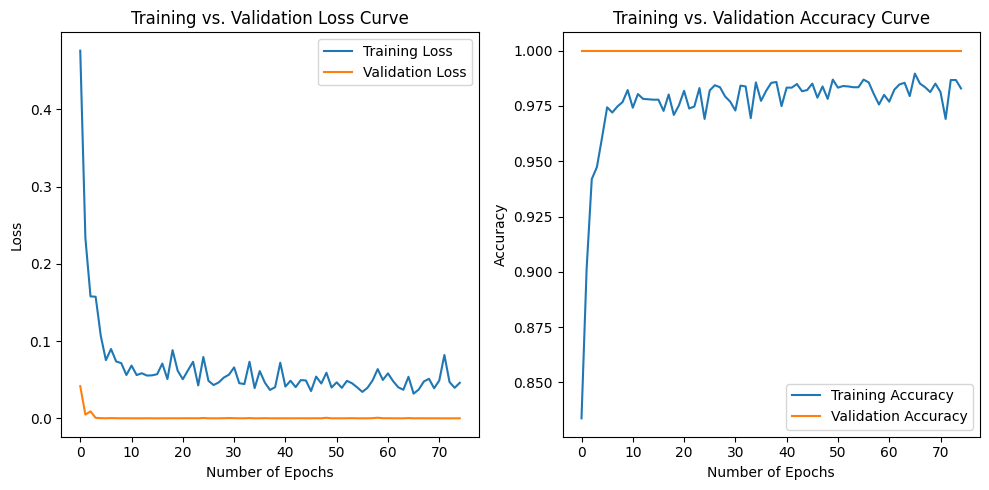

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9928 - loss: 0.0189 
Fold 2:
Accuracy: 0.9901960492134094%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


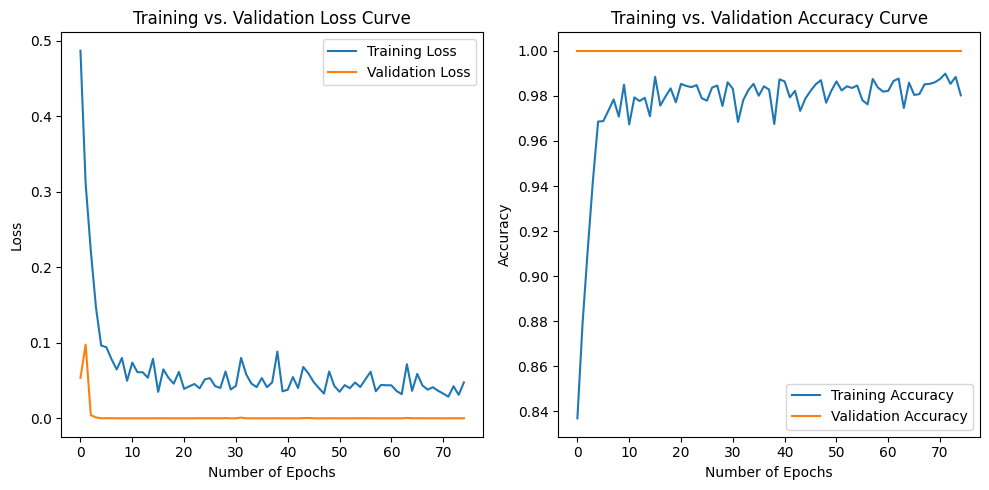

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9943 - loss: 0.0188 
Fold 3:
Accuracy: 0.9915032386779785%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


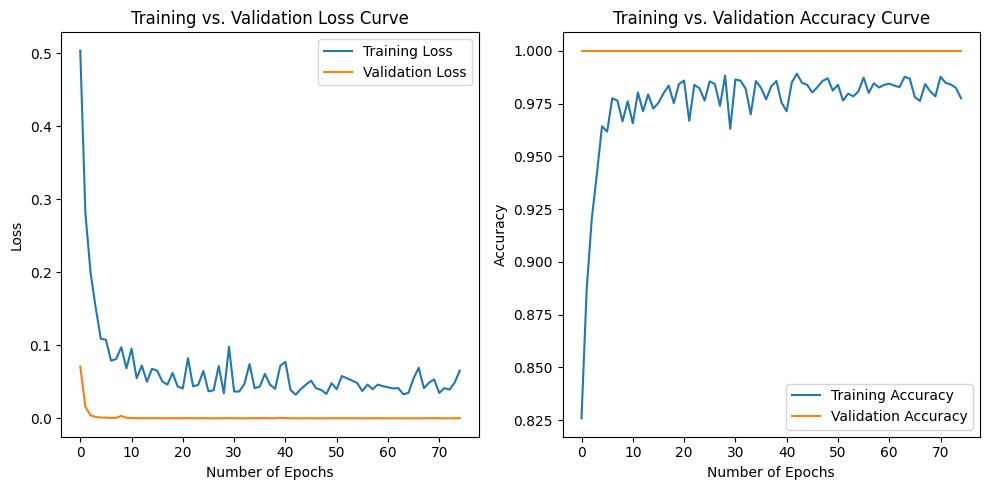

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9883 - loss: 0.0205 
Fold 4:
Accuracy: 0.9928104281425476%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


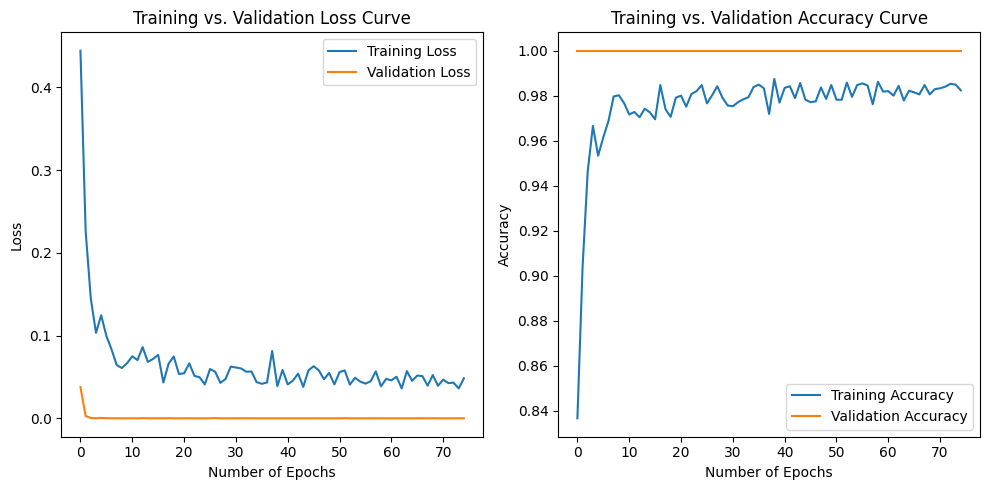

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9797 - loss: 0.1197 
Fold 5:
Accuracy: 0.98562091588974%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


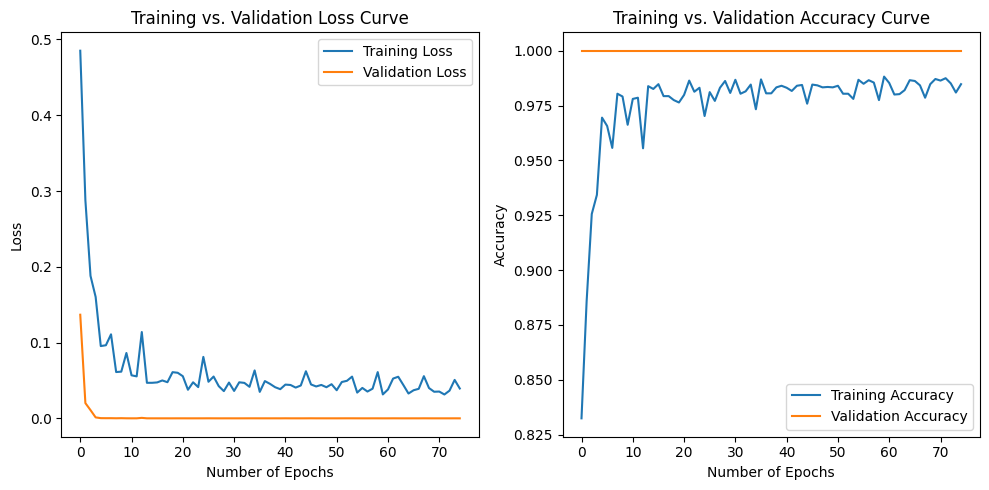

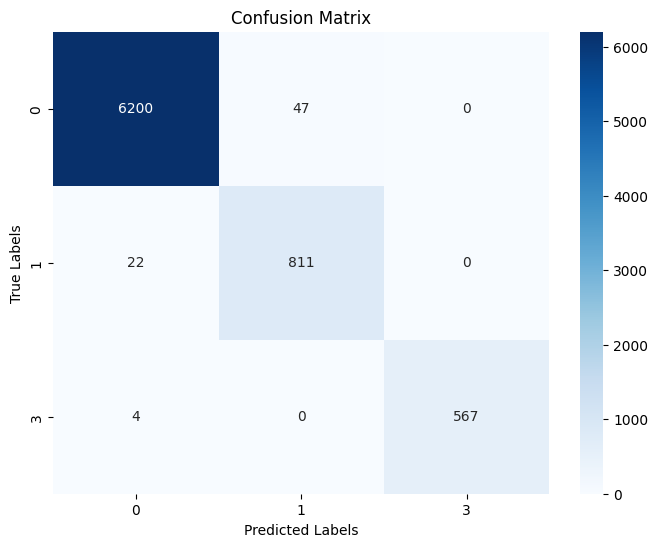


Overall Metrics: 

--Mean Accuracy: 99.04585242271423
--Standard Deviation: 0.2568891621878299
--Macro F1-Score: 0.9833

Class-wise Metrics:
--Precision: [0.99582396 0.94522145 1.        ]
--Recall: [0.992476 0.973589 0.992995]
--F1-Score: [0.99414736 0.95919574 0.99648506]


Time Taken By the model: 133.91682386398315 seconds 




In [48]:
full_mlp_metrics = models.MLP(scaled_full_dataset, labels, 75, dataset_name="Full Dataset")
full_mlp_metrics.print_metrics()

LSTM: Full Dataset

In [49]:
reload_helper()

print("Dataset: Full Dataset")
print("Model: LSTM")
print("--Epochs: 75 \n\n")

Dataset: Full Dataset
Model: LSTM
--Epochs: 75 




/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-------- Fold : 1
Accuracy: 0.9601567387580872
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


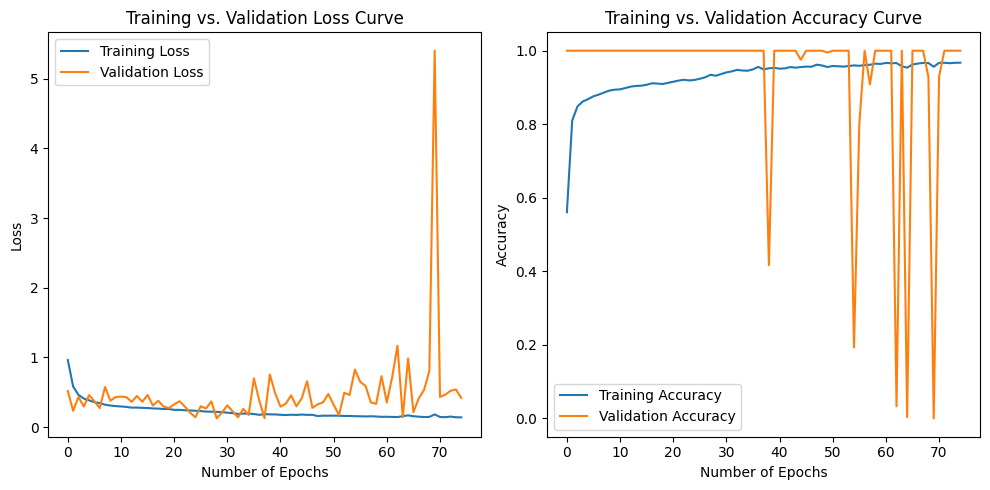


-------- Fold : 2
Accuracy: 0.998039186000824
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


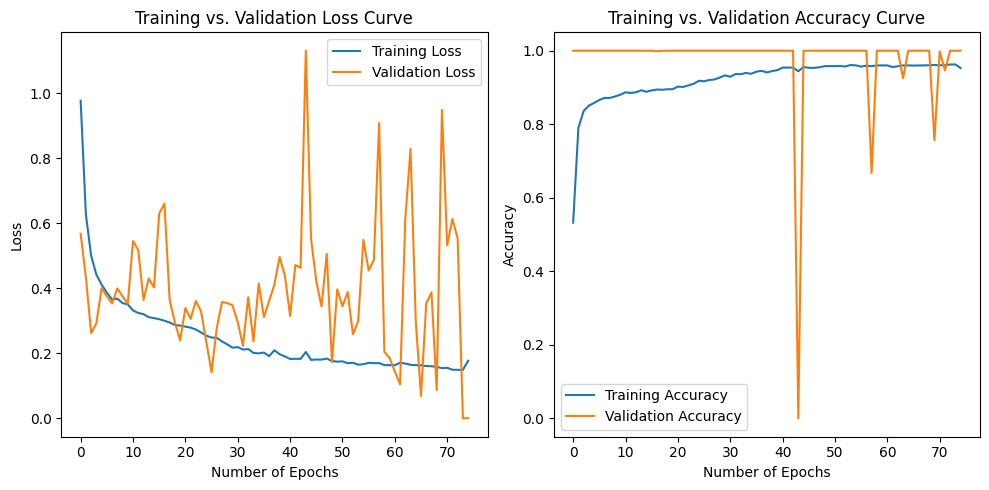


-------- Fold : 3
Accuracy: 0.6352941393852234
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


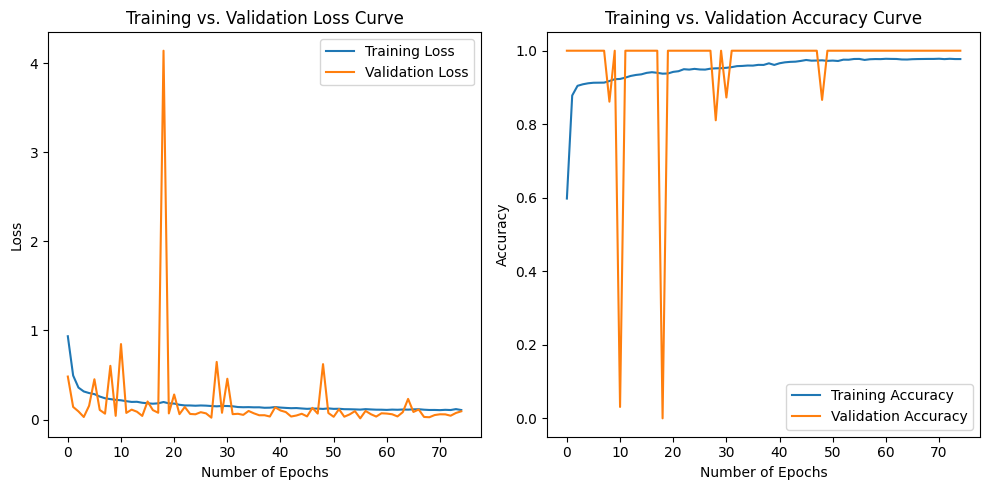


-------- Fold : 4
Accuracy: 0.9379084706306458
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


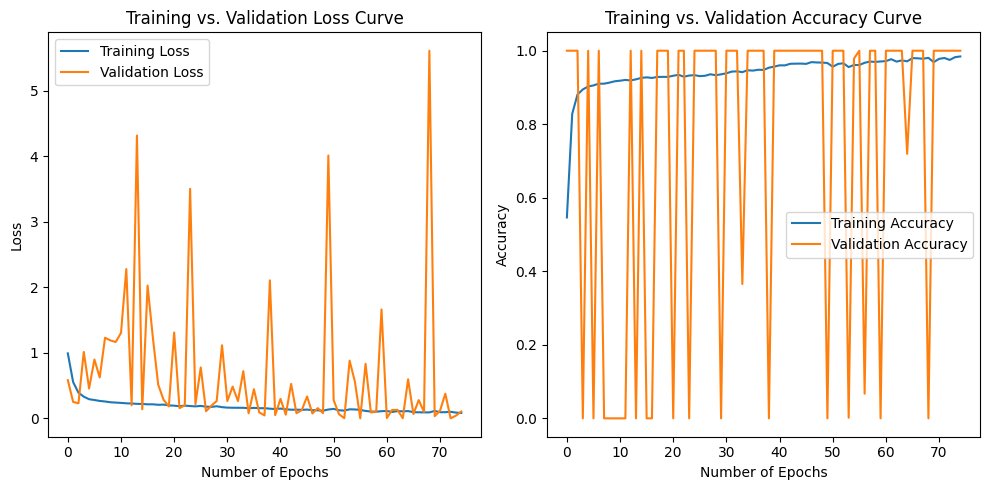


-------- Fold : 5
Accuracy: 0.47647058963775635
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


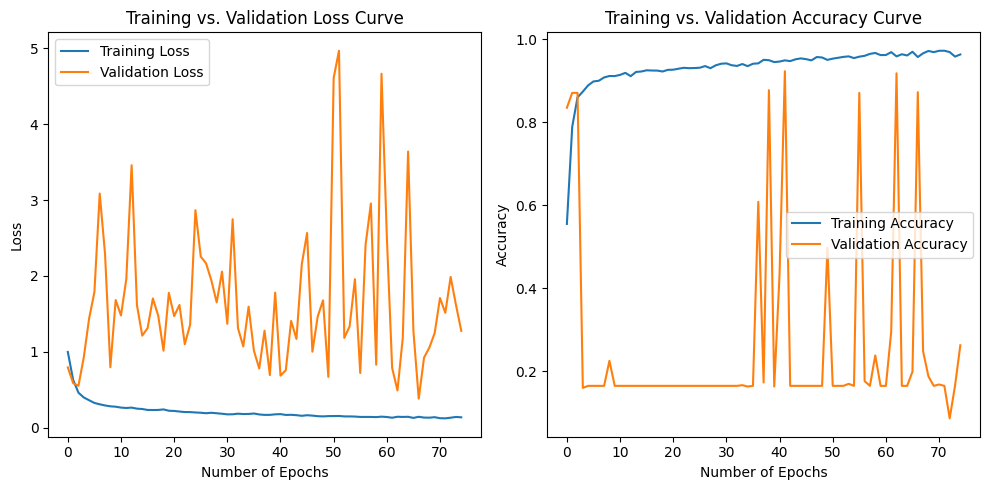

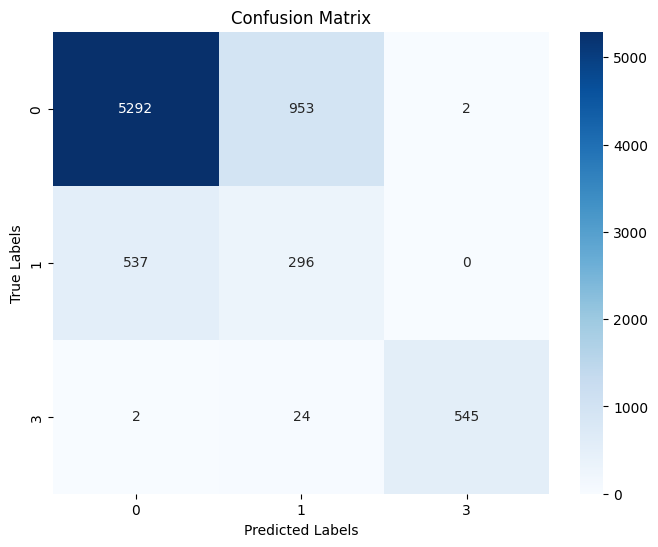


Overall Metrics: 

--Mean Accuracy: 80.15738248825073
--Standard Deviation: 20.768984650173444
--Macro F1-Score: 0.7108

Class-wise Metrics:
--Precision: [0.90756303 0.2325216  0.99634369]
--Recall: [0.847127 0.355342 0.954466]
--F1-Score: [0.87630402 0.28110161 0.97495528]


Time Taken By the model: 523.5360717773438 seconds 




In [50]:
full_lstm_metrics = models.LSTM(scaled_full_dataset, labels=labels, epochs=75, dataset_name="Full Dataset", timesteps=4)
full_lstm_metrics.print_metrics()


Training/Testing on Manually Created Dataset

MLP: Manually Selected Features

In [51]:
reload_helper()

print("Dataset: Manually Created")
print("Model: MLP")
print("Layers: 20 -> 64 -> 128 -> 64 -> 3")
print("--Epochs: 75 \n\n")

Dataset: Manually Created
Model: MLP
Layers: 20 -> 64 -> 128 -> 64 -> 3
--Epochs: 75 




Number of Input Features: 20
Total number of samples: 7651


/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0225 
Fold 1:
Accuracy: 0.9934683442115784%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


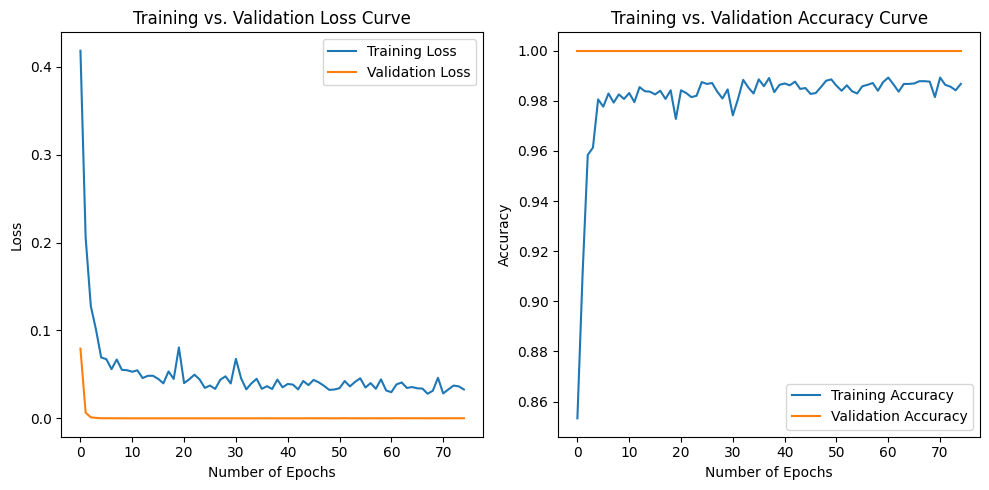

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0307 
Fold 2:
Accuracy: 0.9810457229614258%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


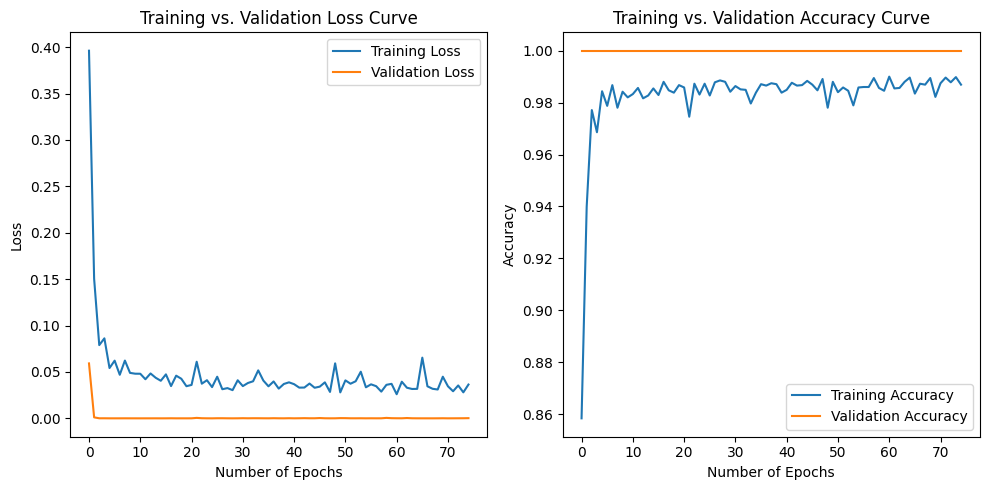

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9950 - loss: 0.0163 
Fold 3:
Accuracy: 0.9921568632125854%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


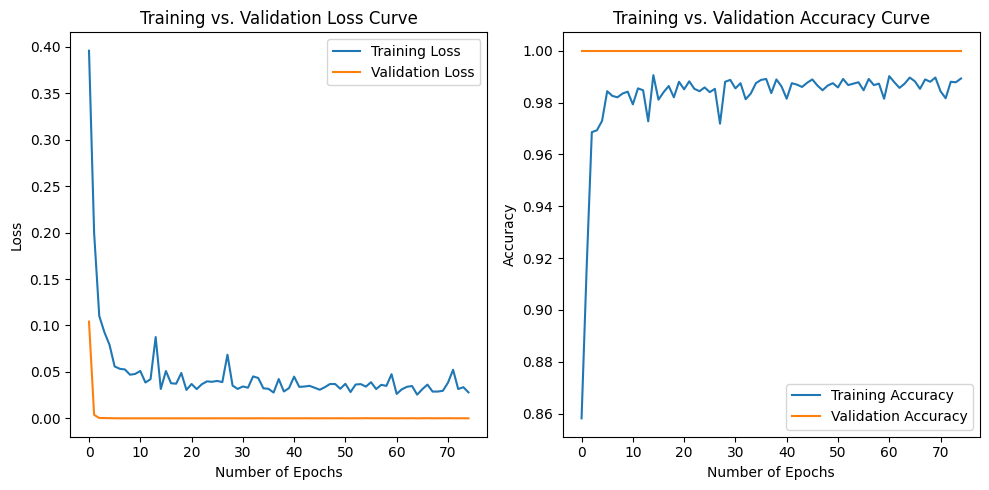

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9990 - loss: 0.0106 
Fold 4:
Accuracy: 0.998039186000824%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


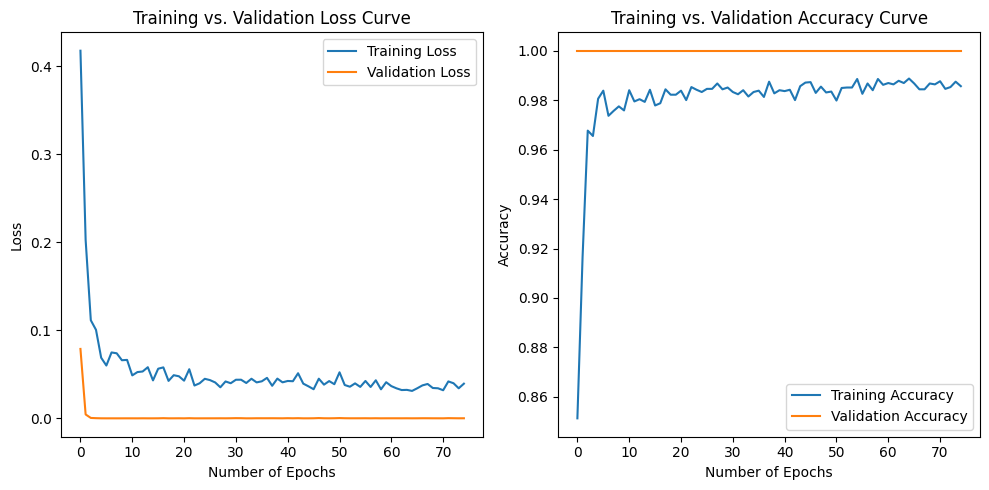

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9797 - loss: 0.0654 
Fold 5:
Accuracy: 0.9862744808197021%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


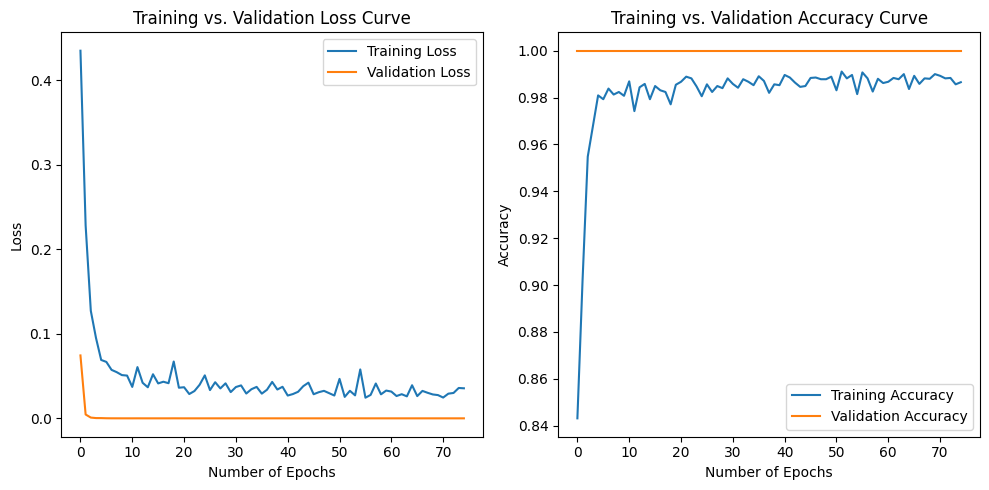

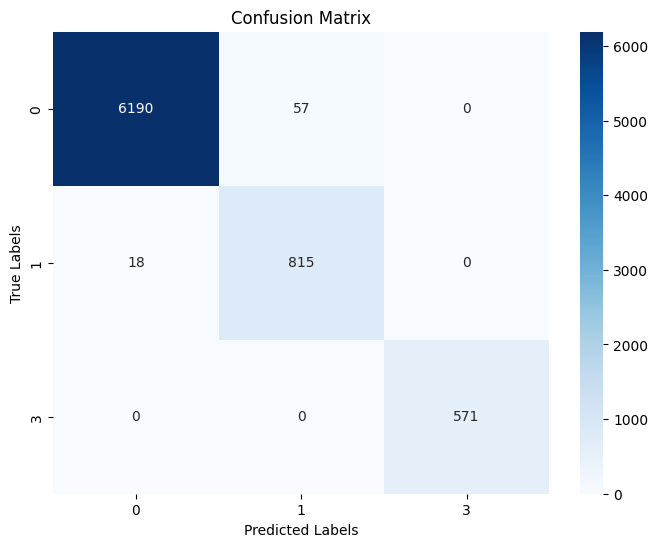


Overall Metrics: 

--Mean Accuracy: 99.01969194412231
--Standard Deviation: 0.5919031443712464
--Macro F1-Score: 0.9833

Class-wise Metrics:
--Precision: [0.99710052 0.93463303 1.        ]
--Recall: [0.990876 0.978391 1.      ]
--F1-Score: [0.99397832 0.95601173 1.        ]


Time Taken By the model: 136.96041703224182 seconds 




In [52]:
md_mlp_metrics = models.MLP(scaled_manual_dataset, labels, 75, dataset_name="Manual_Dataset")
md_mlp_metrics.print_metrics()

LSTM: Manually Created Dataset

In [53]:
reload_helper()

print("Dataset: Manually Created")
print("Model: LSTM")
print("--Epochs: 75 \n\n")


Dataset: Manually Created
Model: LSTM
--Epochs: 75 




/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-------- Fold : 1
Accuracy: 0.9941214919090271
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


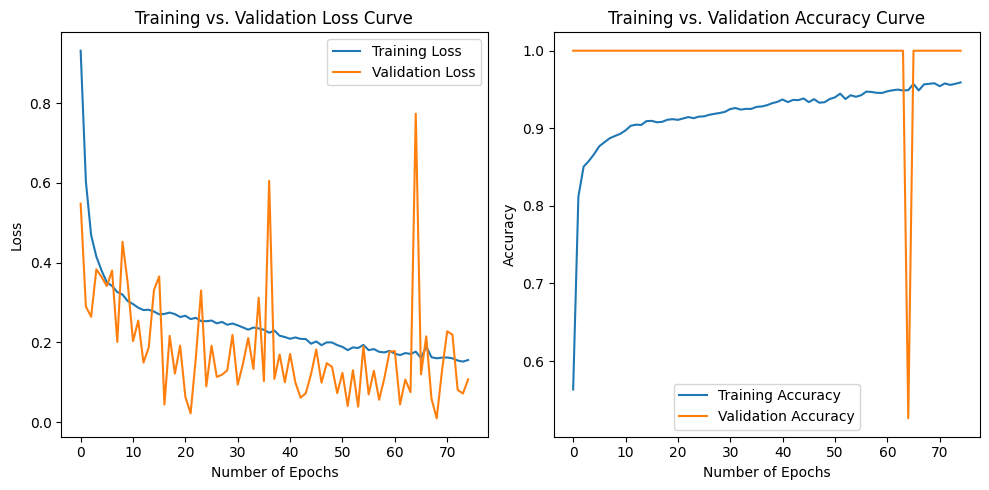


-------- Fold : 2
Accuracy: 0.9915032386779785
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


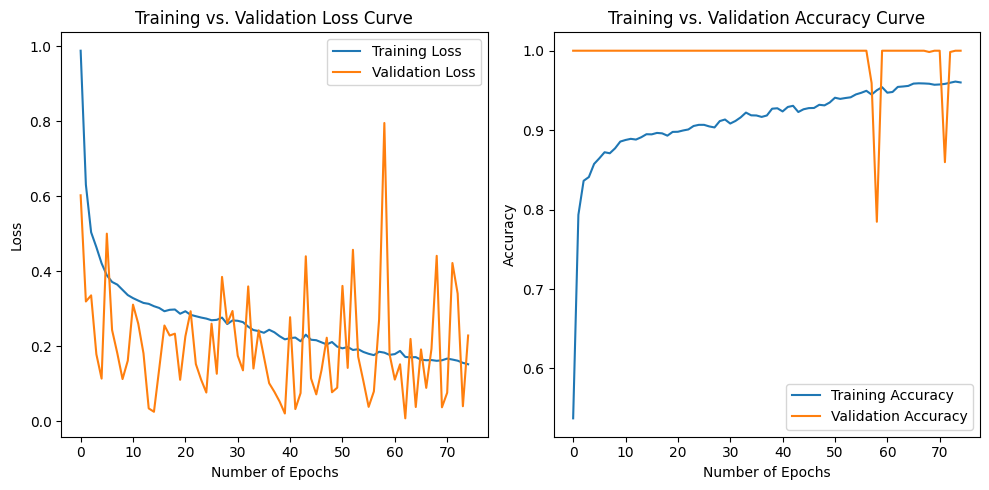


-------- Fold : 3
Accuracy: 0.6470588445663452
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


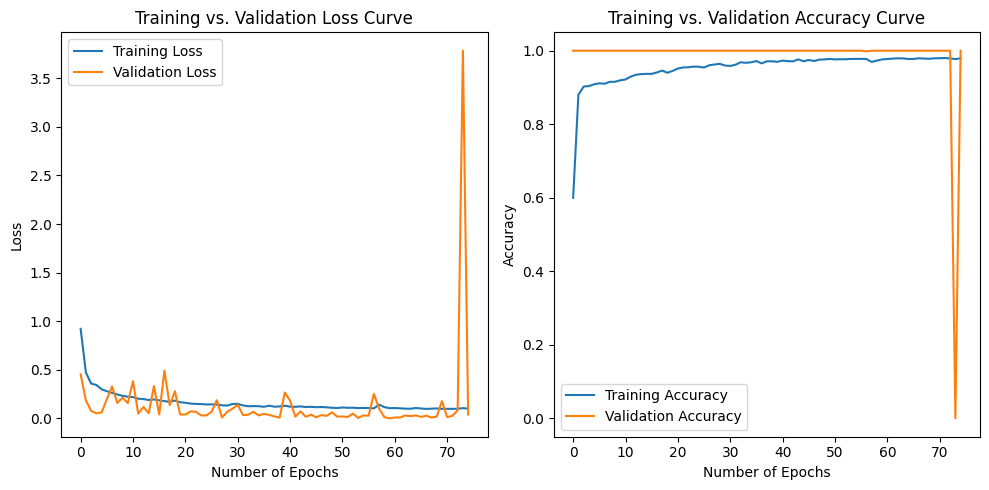


-------- Fold : 4
Accuracy: 0.9111111164093018
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


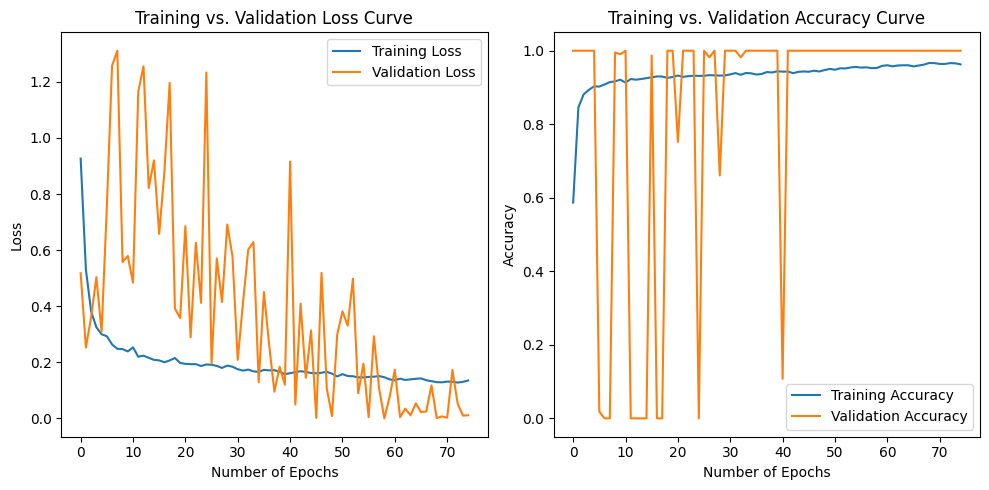


-------- Fold : 5
Accuracy: 0.6764705777168274
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


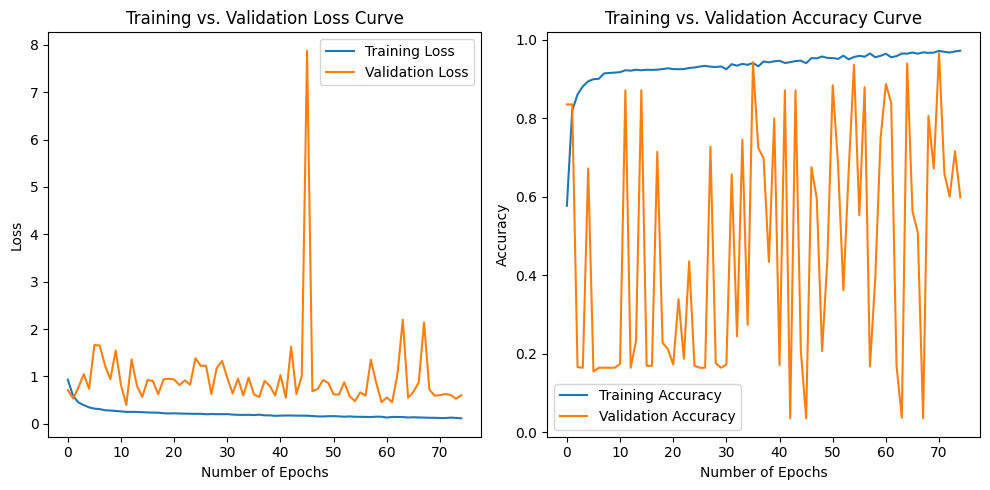

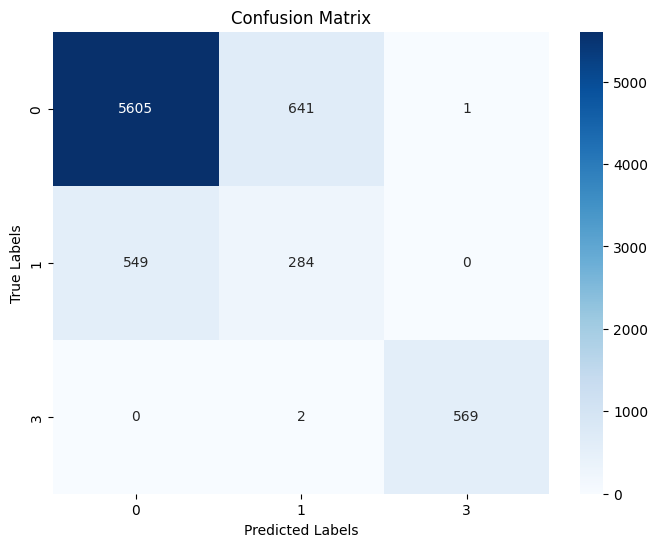


Overall Metrics: 

--Mean Accuracy: 84.4053053855896
--Standard Deviation: 15.208516144562301
--Macro F1-Score: 0.7414

Class-wise Metrics:
--Precision: [0.91078973 0.30636462 0.99824561]
--Recall: [0.897231 0.340936 0.996497]
--F1-Score: [0.90395936 0.32272727 0.99737073]


Time Taken By the model: 537.705269575119 seconds 




In [54]:
md_lstm_metrics = models.LSTM(scaled_manual_dataset, labels=labels, epochs=75, dataset_name="Manual_Dataset", timesteps=4)
md_lstm_metrics.print_metrics()


Training/Testing on PCA dataset

MLP: PCA Dataset

In [55]:
reload_helper()

print("Dataset: PCA")
print("Model: MLP")
print("Layers: 20 -> 64 -> 128 -> 64 -> 3")
print("--Epochs: 75 \n\n")

Dataset: PCA
Model: MLP
Layers: 20 -> 64 -> 128 -> 64 -> 3
--Epochs: 75 




Number of Input Features: 20
Total number of samples: 7651


/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9096 - loss: 0.2081 
Fold 1:
Accuracy: 0.8843892812728882%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


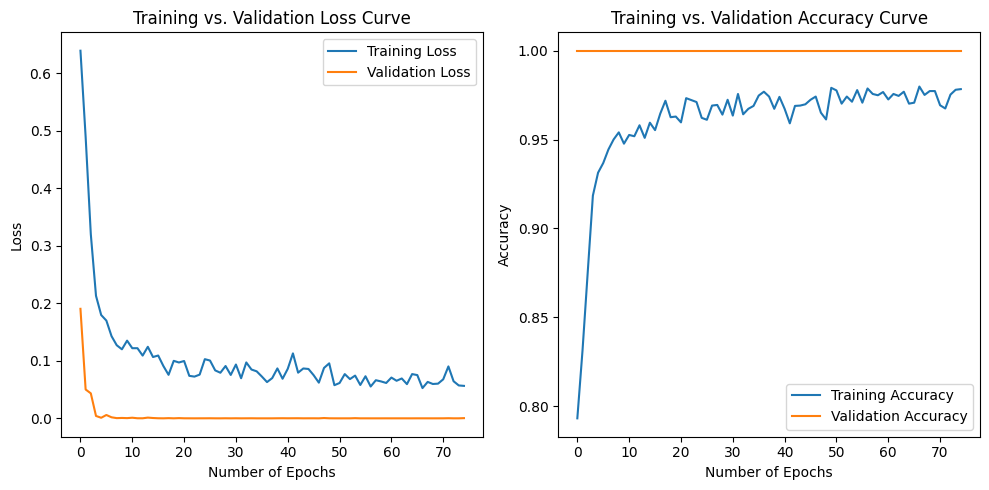

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9823 - loss: 0.0437 
Fold 2:
Accuracy: 0.98562091588974%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


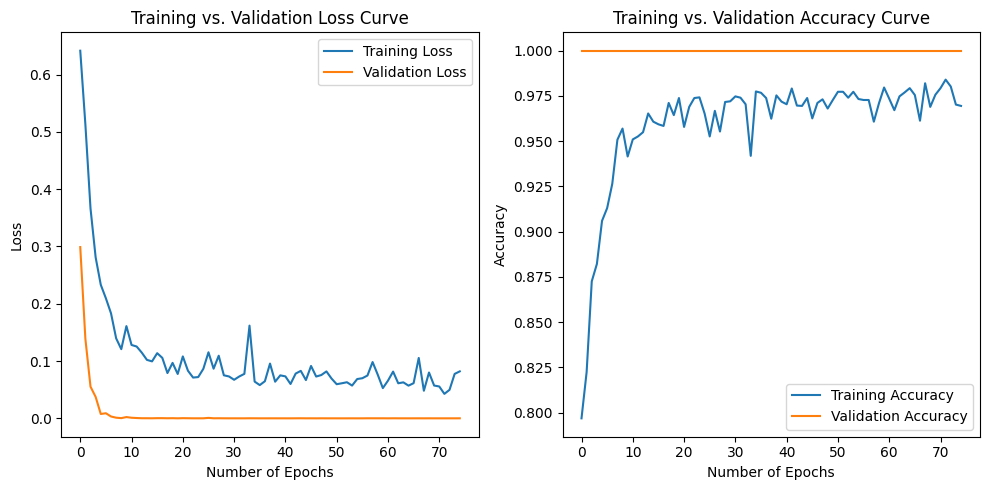

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0215 
Fold 3:
Accuracy: 0.9862744808197021%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


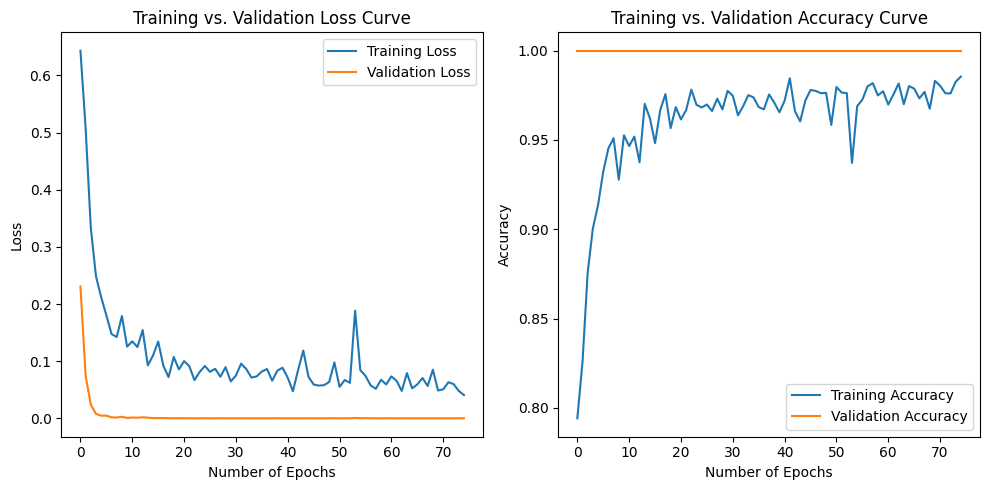

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9806 - loss: 0.0484 
Fold 4:
Accuracy: 0.9666666388511658%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


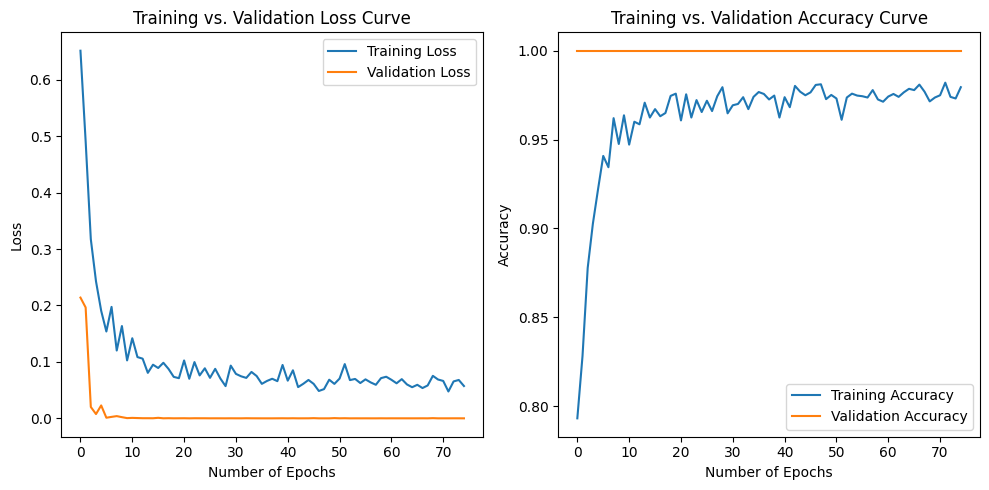

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9809 - loss: 0.0804 
Fold 5:
Accuracy: 0.9699346423149109%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


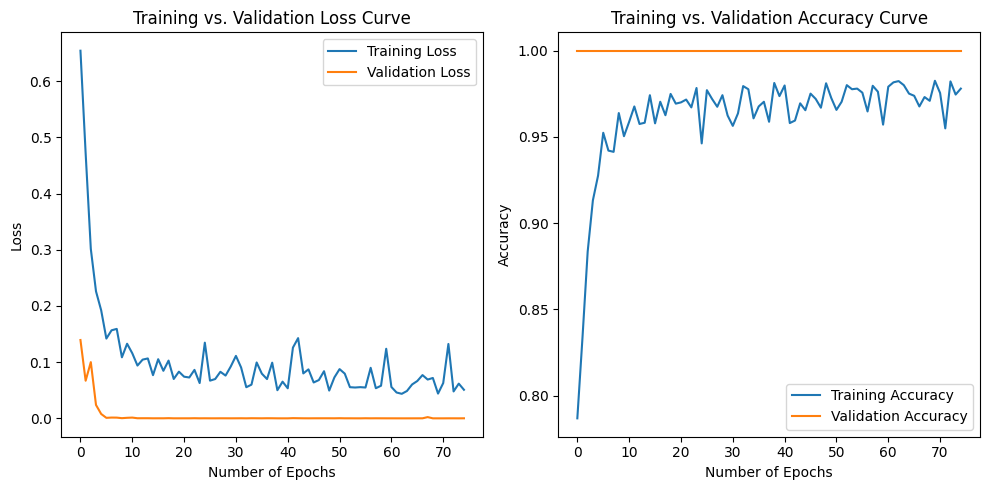

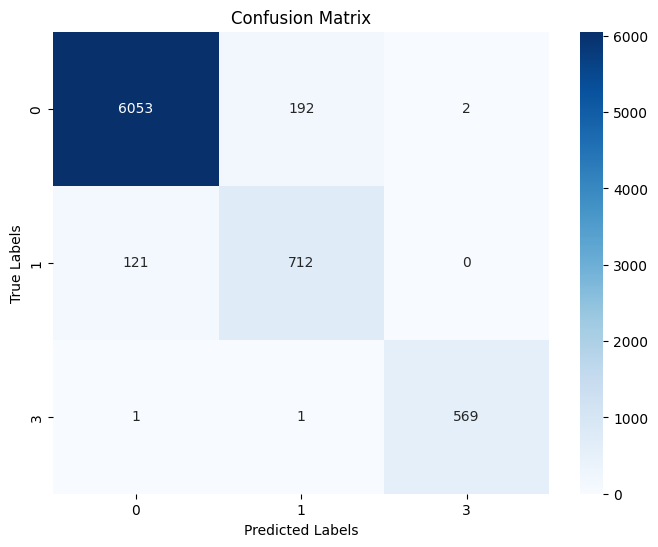


Overall Metrics: 

--Mean Accuracy: 95.85771918296814
--Standard Deviation: 3.7938844831791885
--Macro F1-Score: 0.9301

Class-wise Metrics:
--Precision: [0.98024291 0.78674033 0.99649737]
--Recall: [0.968945 0.854742 0.996497]
--F1-Score: [0.97456126 0.81933257 0.99649737]


Time Taken By the model: 132.7031011581421 seconds 




In [56]:
pca_mlp_metrics = models.MLP(scaled_PCA_dataset, labels, 75, dataset_name="PCA_Dataset")
pca_mlp_metrics.print_metrics()

LSTM: PCA Dataset

In [57]:
reload_helper()

print("Dataset: PCA")
print("Model: LSTM")
print("--Epochs: 75 \n\n")

Dataset: PCA
Model: LSTM
--Epochs: 75 




/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-------- Fold : 1
Accuracy: 0.9934683442115784
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


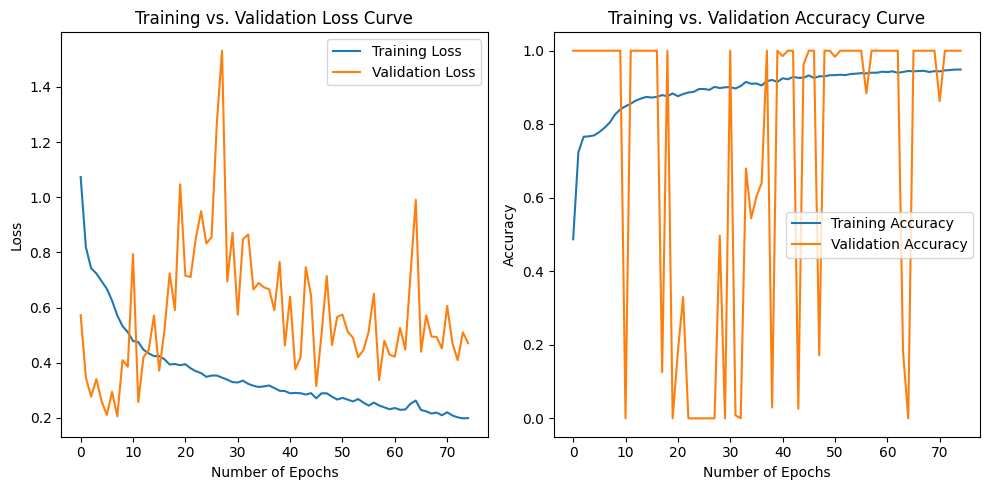


-------- Fold : 2
Accuracy: 0.9444444179534912
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


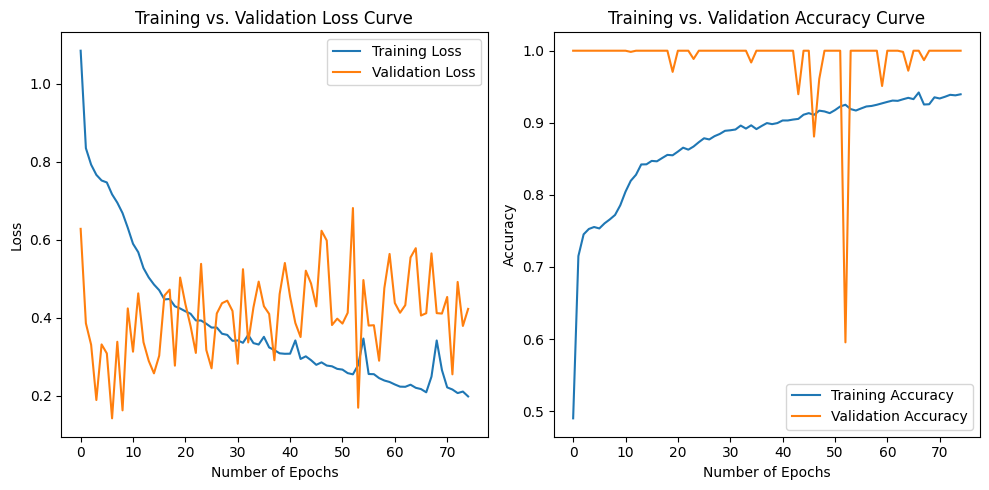


-------- Fold : 3
Accuracy: 0.6522876024246216
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


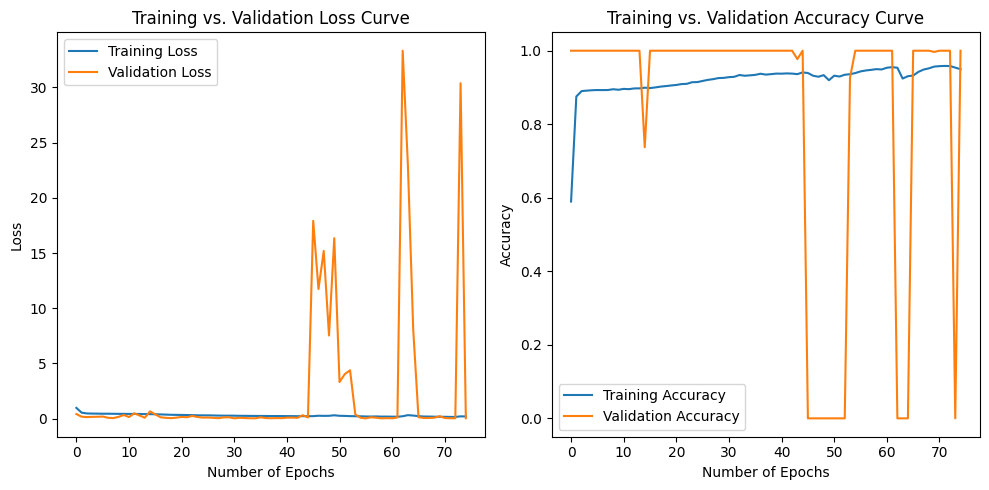


-------- Fold : 4
Accuracy: 0.8222222328186035
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


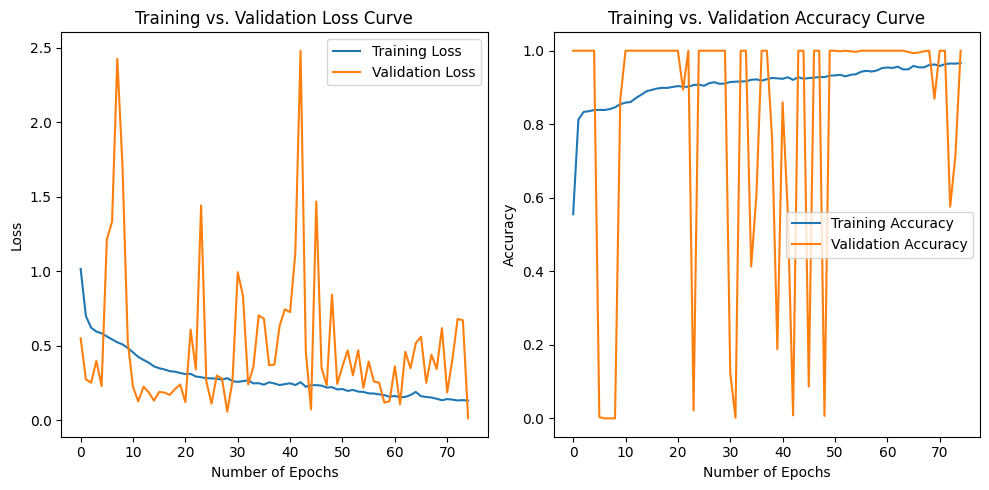


-------- Fold : 5
Accuracy: 0.0
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


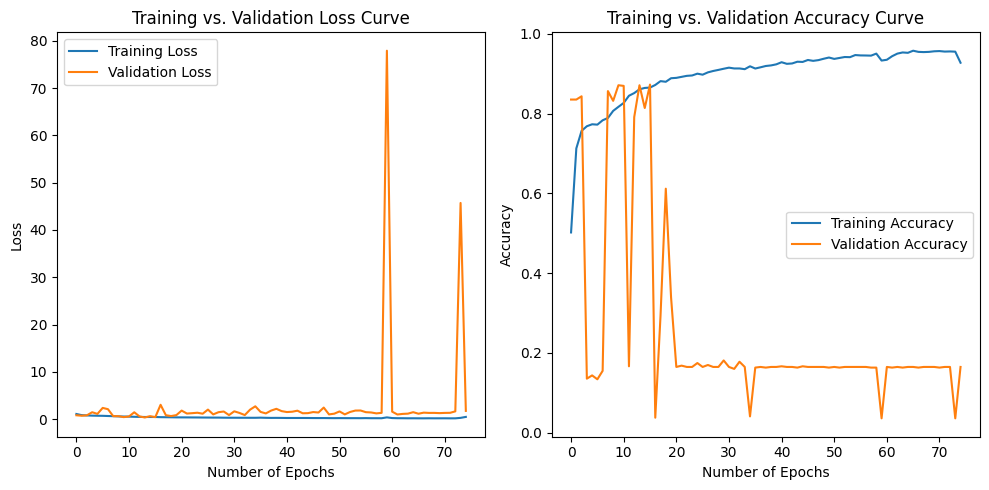

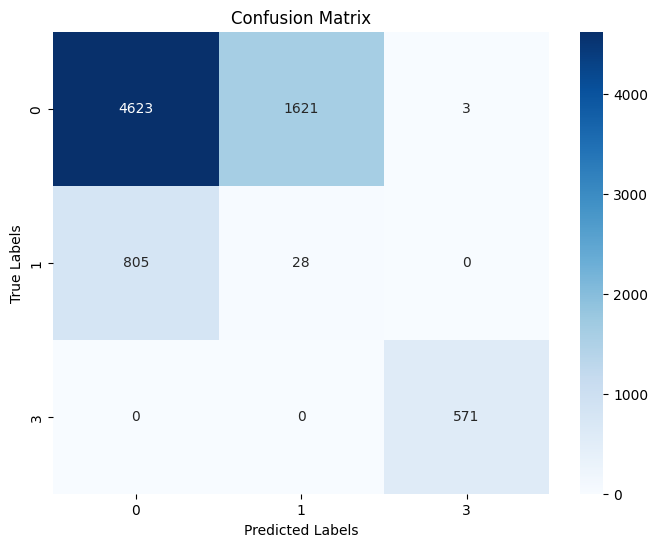


Overall Metrics: 

--Mean Accuracy: 68.2484519481659
--Standard Deviation: 36.09868499852926
--Macro F1-Score: 0.6040

Class-wise Metrics:
--Precision: [0.85169492 0.01697999 0.99477352]
--Recall: [0.740035 0.033613 1.      ]
--F1-Score: [0.79194861 0.02256245 0.99737991]


Time Taken By the model: 469.5133287906647 seconds 




In [58]:
pca_lstm_metrics = models.LSTM(scaled_PCA_dataset, labels, 75, dataset_name="PCA_Dataset", timesteps=4)
pca_lstm_metrics.print_metrics()

Training/Testing on Feature Engine Dataset

MLP: SmartFeatureSelection

In [59]:
reload_helper()

print("Dataset: Smart Feature Selection")
print("Model: MLP")
print("Layers: 24 -> 64 -> 128 -> 64 -> 3")
print("--Epochs: 75 \n\n")

Dataset: Smart Feature Selection
Model: MLP
Layers: 24 -> 64 -> 128 -> 64 -> 3
--Epochs: 75 




Number of Input Features: 24
Total number of samples: 7651


/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9899 - loss: 0.0366 
Fold 1:
Accuracy: 0.9902024865150452%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


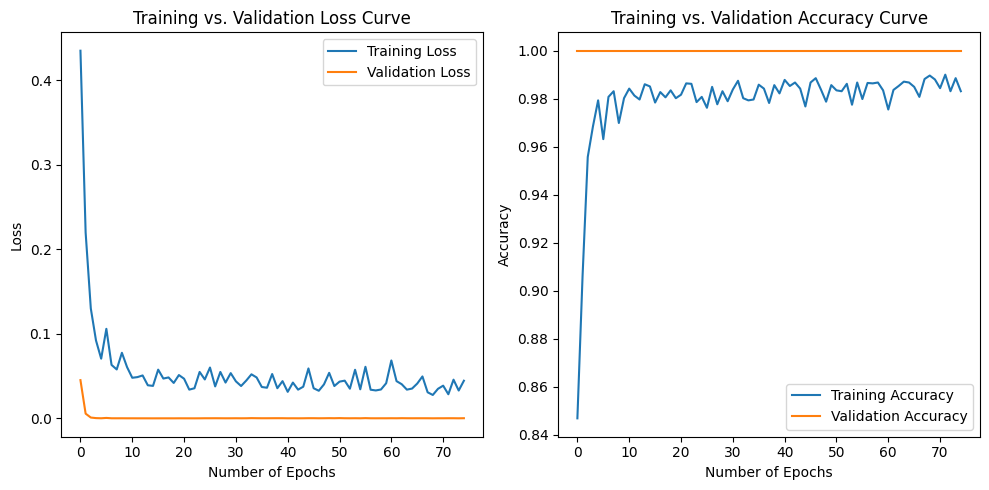

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0246
Fold 2:
Accuracy: 0.9928104281425476%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


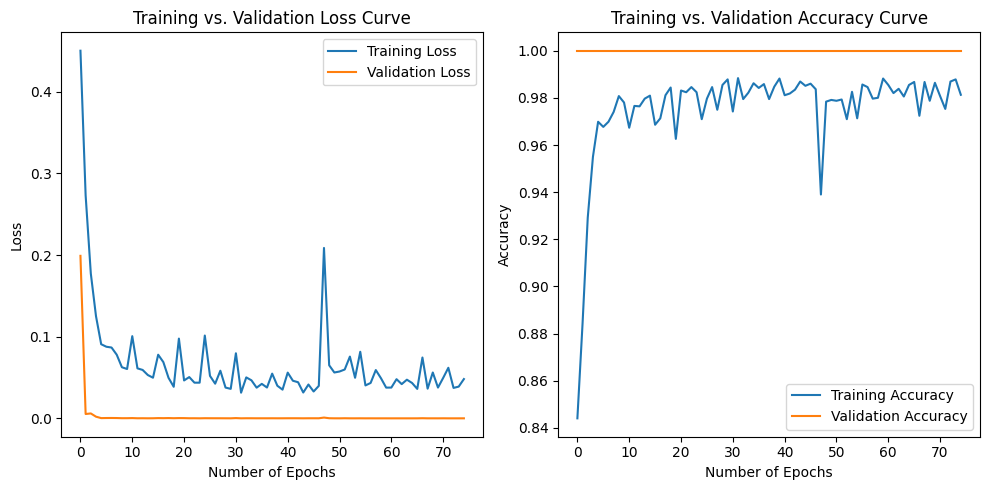

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9949 - loss: 0.0148 
Fold 3:
Accuracy: 0.9915032386779785%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


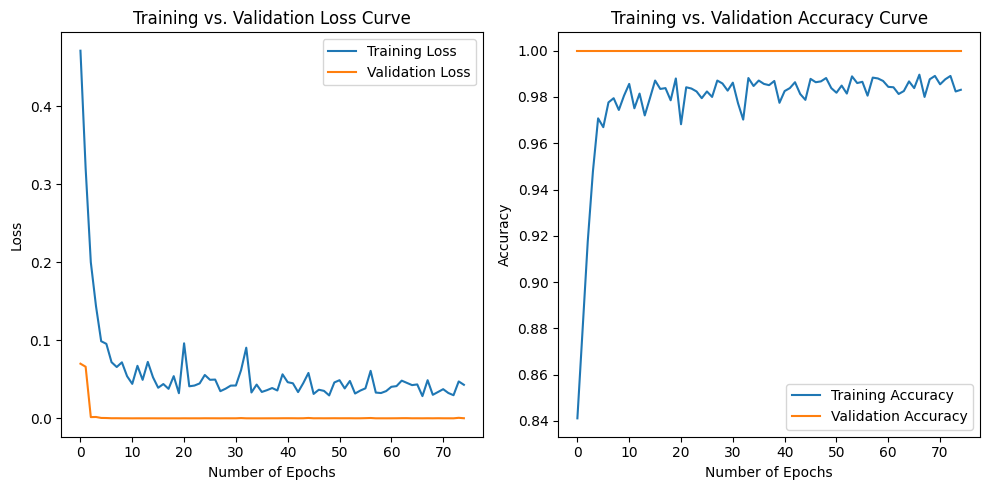

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0135 
Fold 4:
Accuracy: 0.9928104281425476%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


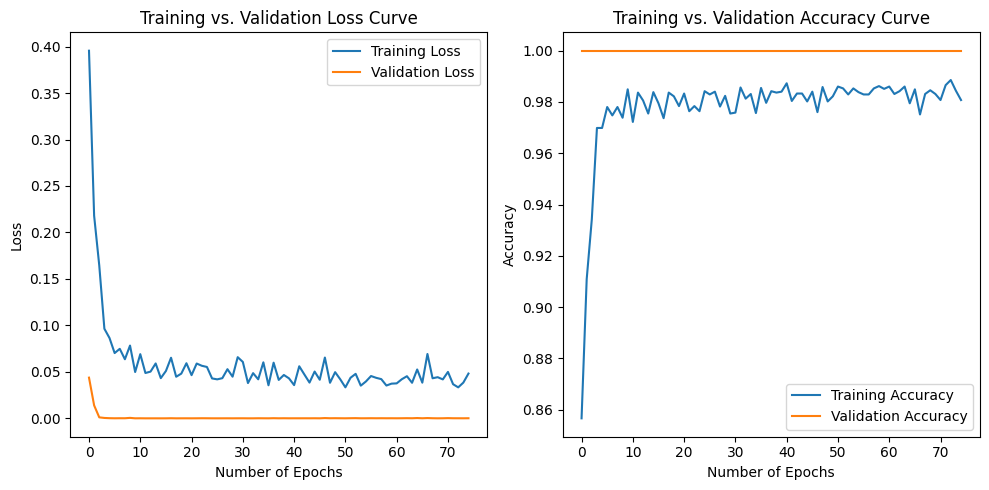

/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0662 
Fold 5:
Accuracy: 0.9862744808197021%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


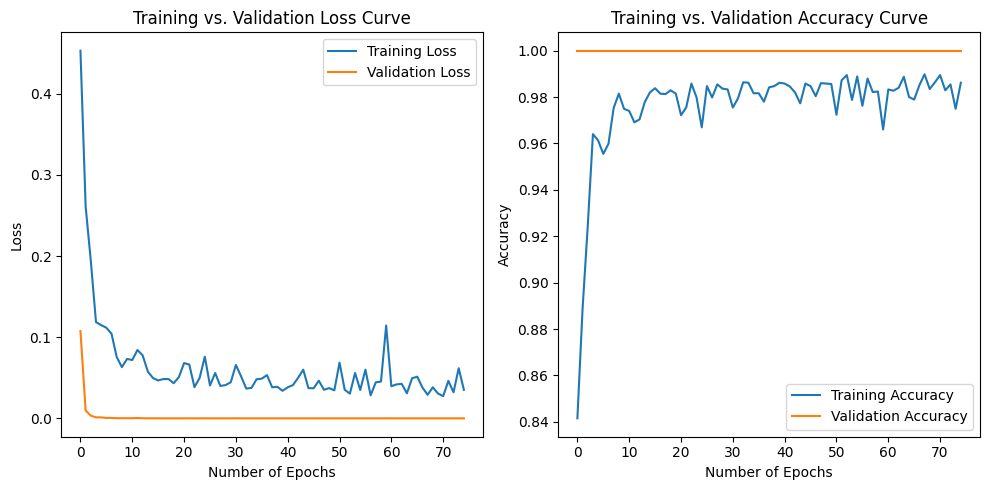

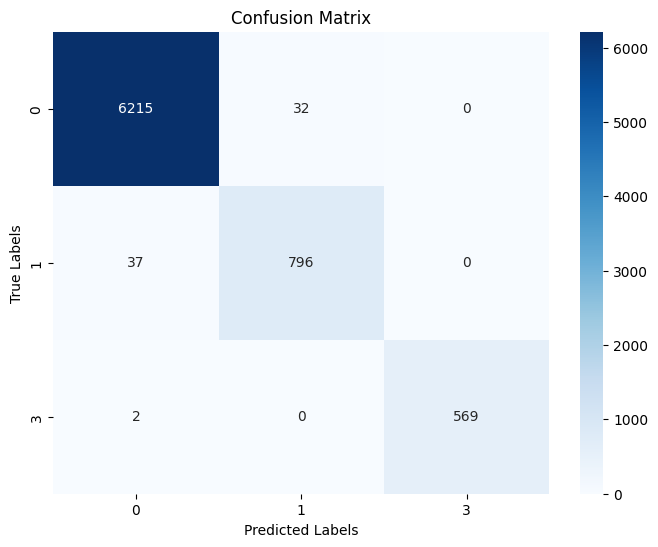


Overall Metrics: 

--Mean Accuracy: 99.07202124595642
--Standard Deviation: 0.24241989699198566
--Macro F1-Score: 0.9837

Class-wise Metrics:
--Precision: [0.99376399 0.96135266 1.        ]
--Recall: [0.994878 0.955582 0.996497]
--F1-Score: [0.99432045 0.95845876 0.99824561]


Time Taken By the model: 129.2503218650818 seconds 




In [60]:
fe_mlp_metrics = models.MLP(scaled_feature_engine_dataset, labels, 75, dataset_name="Smart_Feature_Selection")
fe_mlp_metrics.print_metrics()


LSTM: SmartFeatureSelection

In [61]:
reload_helper()

print("Dataset: Smart Feature Selection")
print("Model: LSTM")
print("--Epochs: 75 \n\n")

Dataset: Smart Feature Selection
Model: LSTM
--Epochs: 75 




/home/ashutoshr/Deep-Learning/deepenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-------- Fold : 1
Accuracy: 0.8497713804244995
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


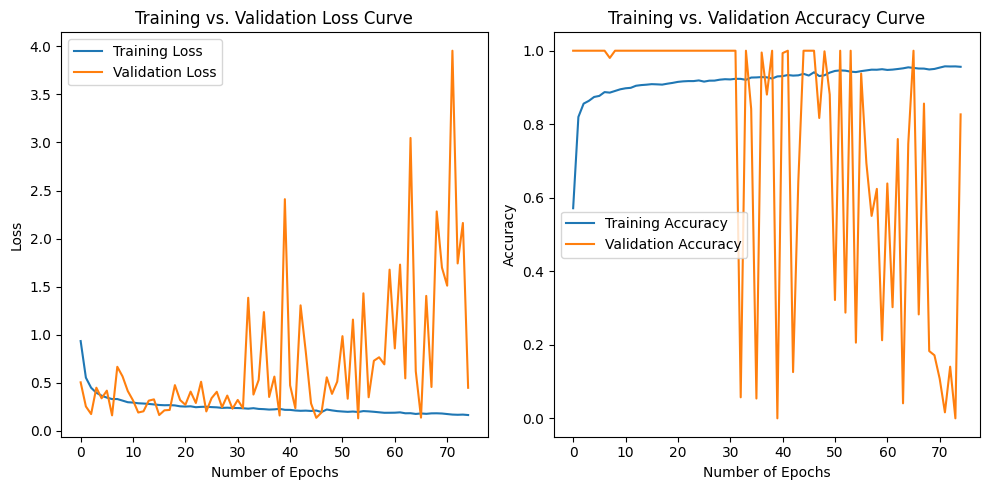


-------- Fold : 2
Accuracy: 0.998039186000824
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


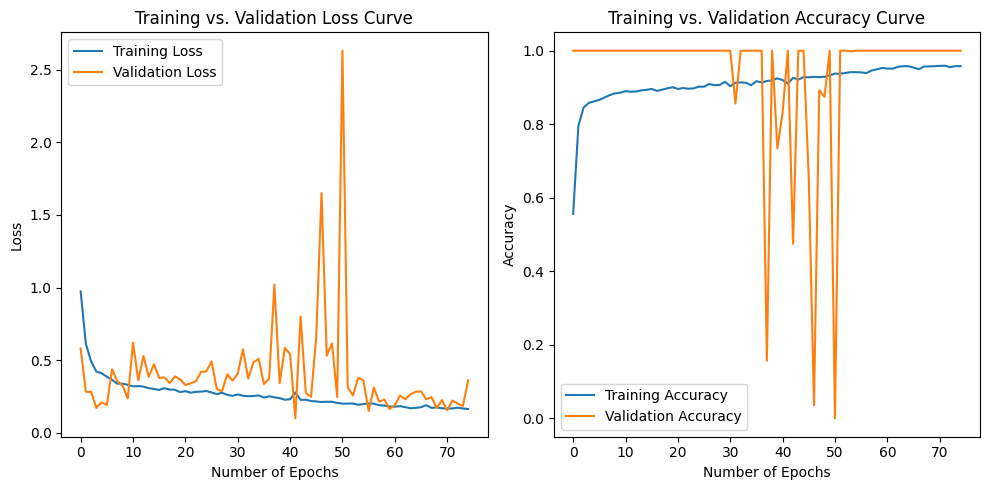


-------- Fold : 3
Accuracy: 0.8679738640785217
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


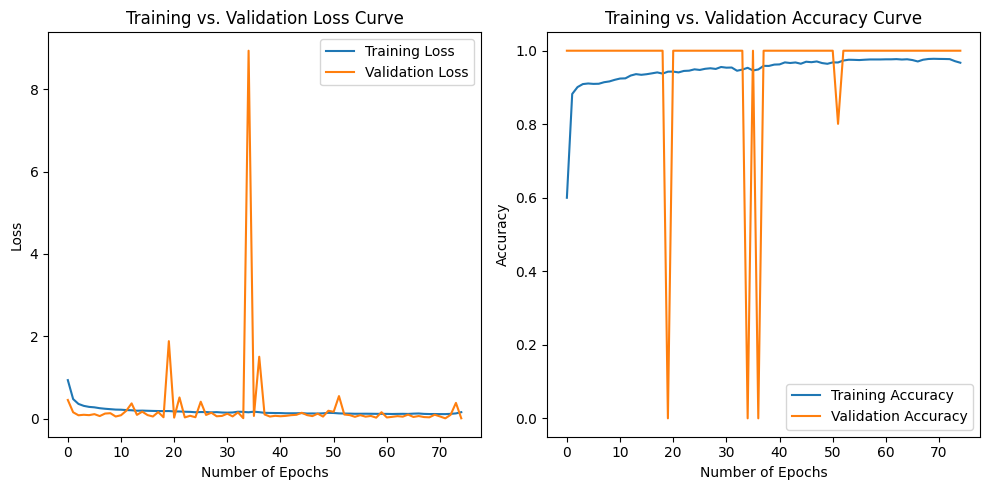


-------- Fold : 4
Accuracy: 0.8633986711502075
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


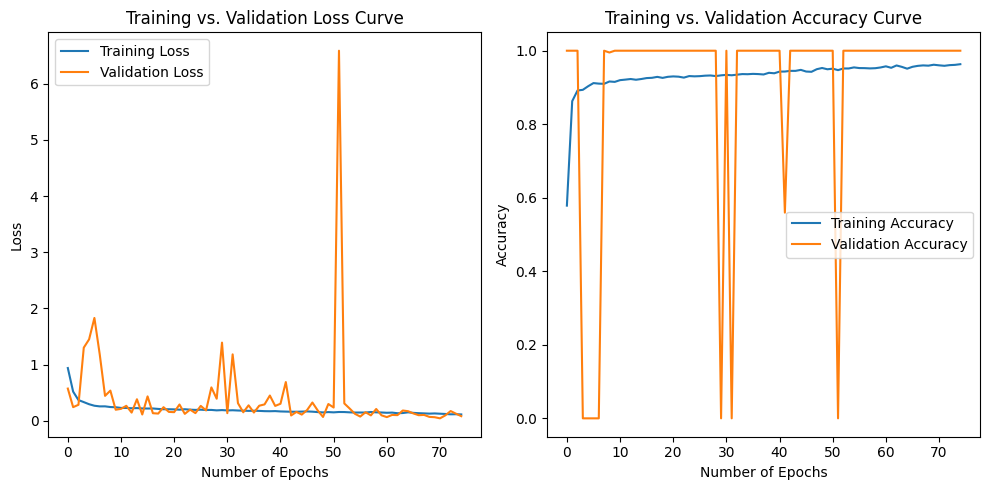


-------- Fold : 5
Accuracy: 0.7692810297012329
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


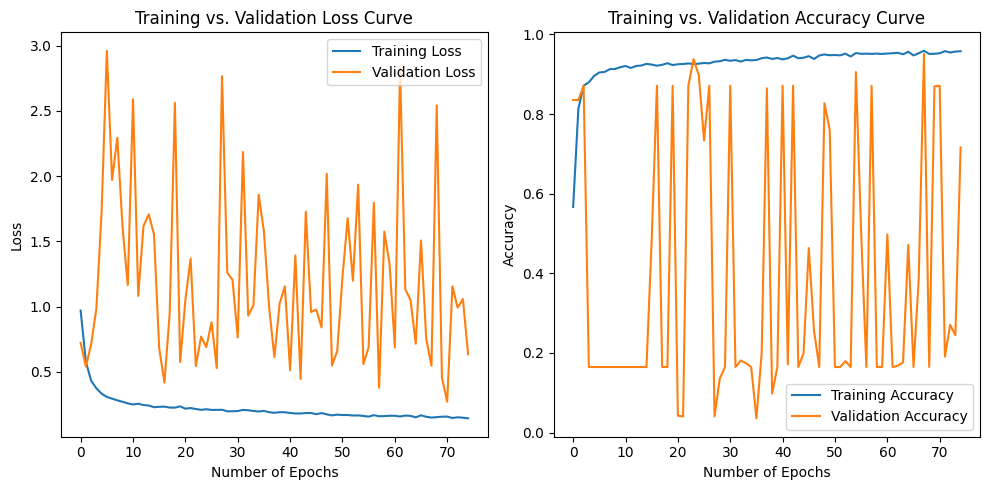

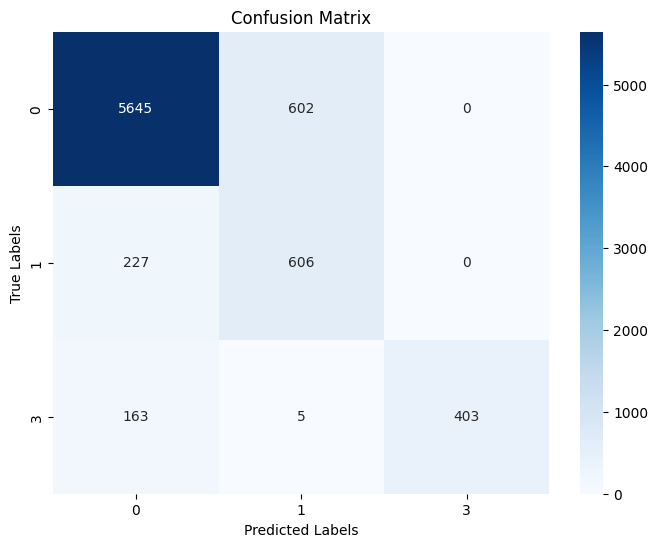


Overall Metrics: 

--Mean Accuracy: 86.96928262710571
--Standard Deviation: 7.347755054516242
--Macro F1-Score: 0.7797

Class-wise Metrics:
--Precision: [0.93537697 0.4995878  1.        ]
--Recall: [0.903634 0.727491 0.705779]
--F1-Score: [0.9192314  0.59237537 0.8275154 ]


Time Taken By the model: 472.7940456867218 seconds 




In [62]:
fe_lstm_metrics = models.LSTM(scaled_feature_engine_dataset, labels, 75, dataset_name="Smart_Feature_Selection", timesteps=4)
fe_lstm_metrics.print_metrics()

Comparision of Models on Different Datasets

In [104]:
datasets = ["Full Dataset", "Manualy Selected Features", "PCA", "Smart Feature Selection"]
models = ["MLP", "LSTM"]

mlp_accuracies = [full_mlp_metrics.mean_accuracy, md_mlp_metrics.mean_accuracy, pca_mlp_metrics.mean_accuracy, fe_mlp_metrics.mean_accuracy]
lstm_accuracies = [full_lstm_metrics.mean_accuracy, md_lstm_metrics.mean_accuracy, pca_lstm_metrics.mean_accuracy, fe_lstm_metrics.mean_accuracy]

mlp_time_taken = [full_mlp_metrics.time_taken, md_mlp_metrics.time_taken, pca_mlp_metrics.time_taken, fe_mlp_metrics.time_taken]
lstm_time_taken = [full_lstm_metrics.time_taken, md_lstm_metrics.time_taken, pca_lstm_metrics.time_taken, fe_lstm_metrics.time_taken]

mlp_f1_score = [full_mlp_metrics.f1_score, md_mlp_metrics.f1_score, pca_mlp_metrics.f1_score, fe_mlp_metrics.f1_score]
lstm_f1_score = [full_lstm_metrics.f1_score, md_lstm_metrics.f1_score, pca_lstm_metrics.f1_score, fe_lstm_metrics.f1_score]

mlp_std_deviation = [full_mlp_metrics.std_deviation, md_mlp_metrics.std_deviation, pca_mlp_metrics.std_deviation, fe_mlp_metrics.std_deviation]
lstm_std_deviation = [full_lstm_metrics.std_deviation, md_lstm_metrics.std_deviation, pca_lstm_metrics.std_deviation, fe_lstm_metrics.std_deviation]

mlp_precision = [full_mlp_metrics.precision, md_mlp_metrics.precision, pca_mlp_metrics.precision, fe_mlp_metrics.precision]
lstm_precision = [full_lstm_metrics.precision, md_lstm_metrics.precision, pca_lstm_metrics.precision, fe_lstm_metrics.precision]

mlp_recall = [full_mlp_metrics.recall, md_mlp_metrics.recall, pca_mlp_metrics.recall, fe_mlp_metrics.recall]
lstm_recall = [full_lstm_metrics.recall, md_lstm_metrics.recall, pca_lstm_metrics.recall, fe_lstm_metrics.recall]


Comparing the mean accuracy of each model accross all datasets

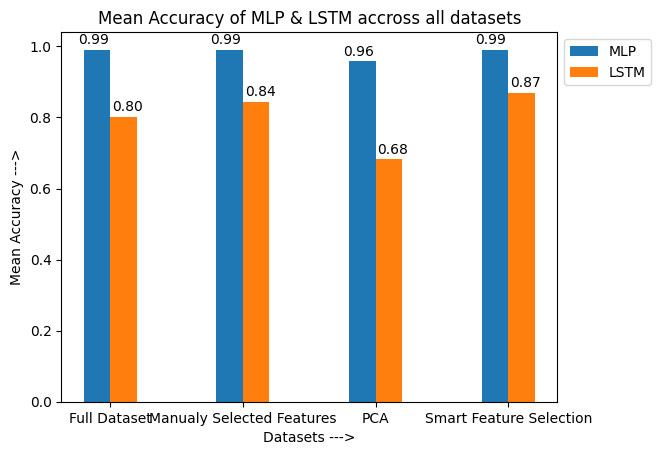

In [95]:
reload_helper()

title = "Mean Accuracy of MLP & LSTM accross all datasets"
plotter.plot_grouped_bar_chart(datasets, models, mlp_accuracies,lstm_accuracies, title=title, y_label="Mean Accuracy",left_margin=0.03, right_margin=0.03)

Plotting the total time taken by the models on all datasets

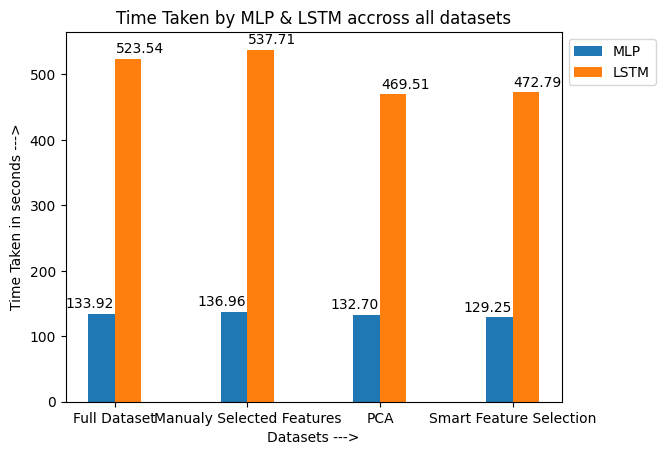

In [96]:
title = "Time Taken by MLP & LSTM accross all datasets"
plotter.plot_grouped_bar_chart(datasets, models, mlp_time_taken,lstm_time_taken, title=title, y_label="Time Taken in seconds", left_margin=0.09, right_margin=0.09)

Comparing F1-Score of all models

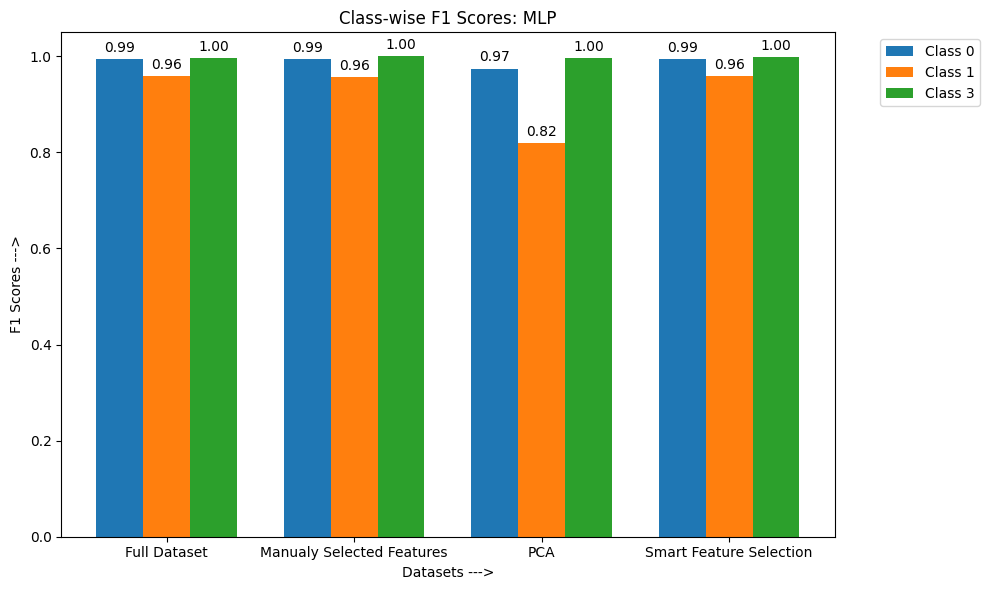

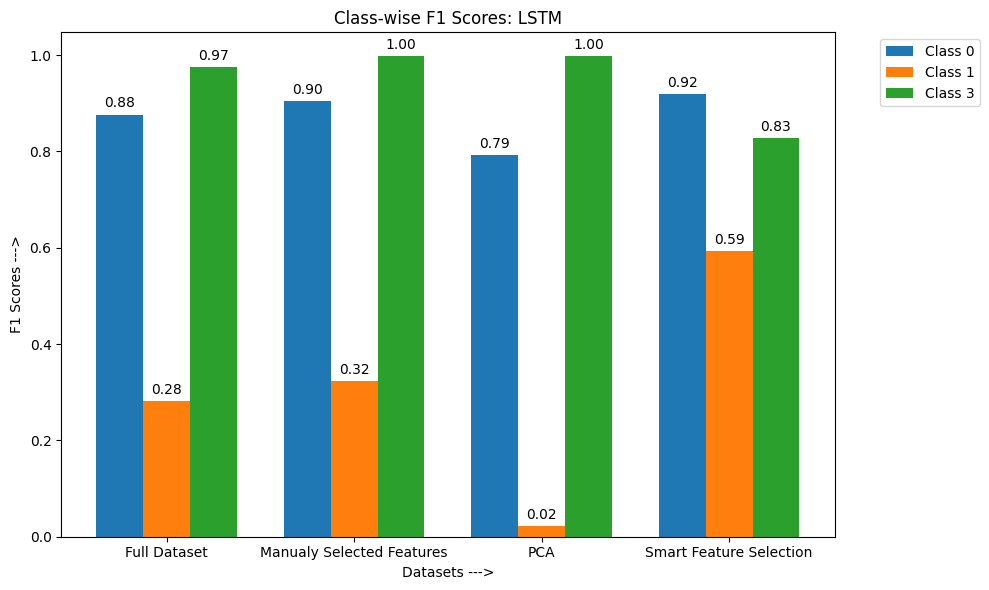

In [102]:
reload_helper()
plotter.plot_class_wise_barchart(datasets, mlp_f1_score, title="Class-wise F1 Scores", y_label="F1 Scores", model_name="MLP")
plotter.plot_class_wise_barchart(datasets, lstm_f1_score, title="Class-wise F1 Scores", y_label="F1 Scores",model_name="LSTM")

Comparing the Standard deviation of all models

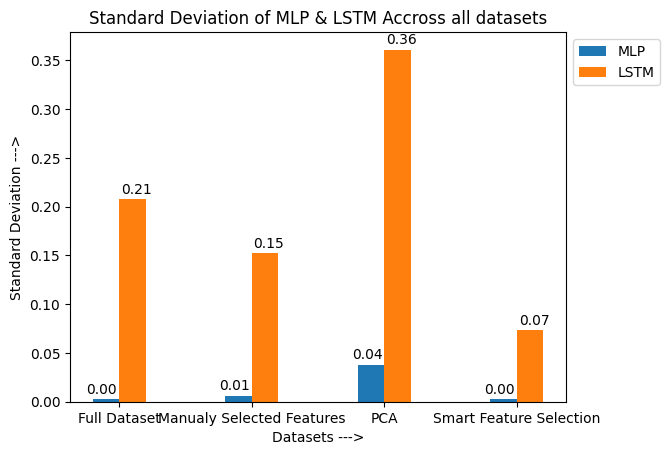

In [98]:
title = "Standard Deviation of MLP & LSTM Accross all datasets"
plotter.plot_grouped_bar_chart(datasets, models, mlp_std_deviation,lstm_std_deviation, title=title, y_label="Standard Deviation", left_margin=0.03, right_margin=0.03)

Comparing precision of the models accross datasets

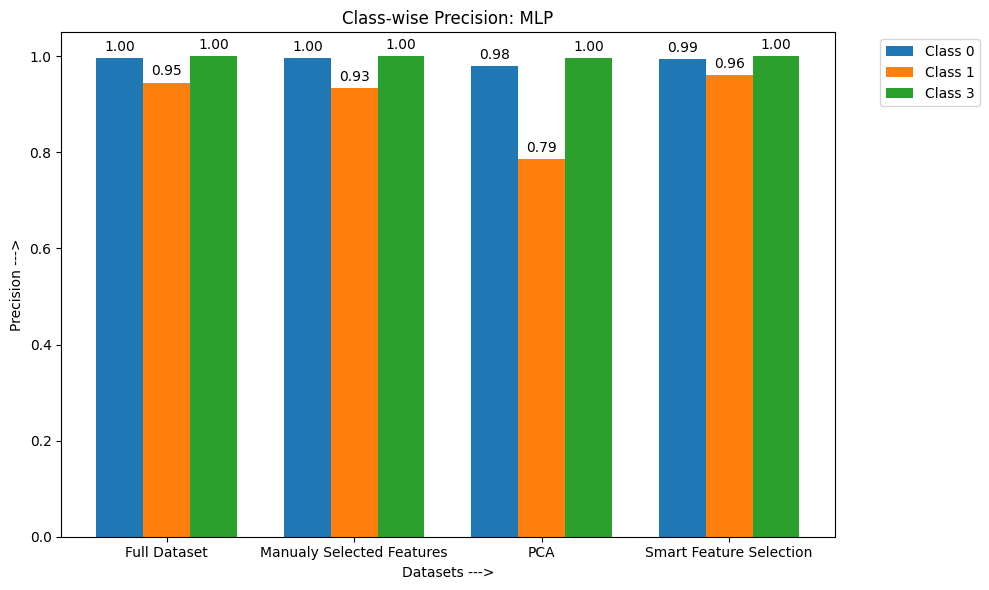

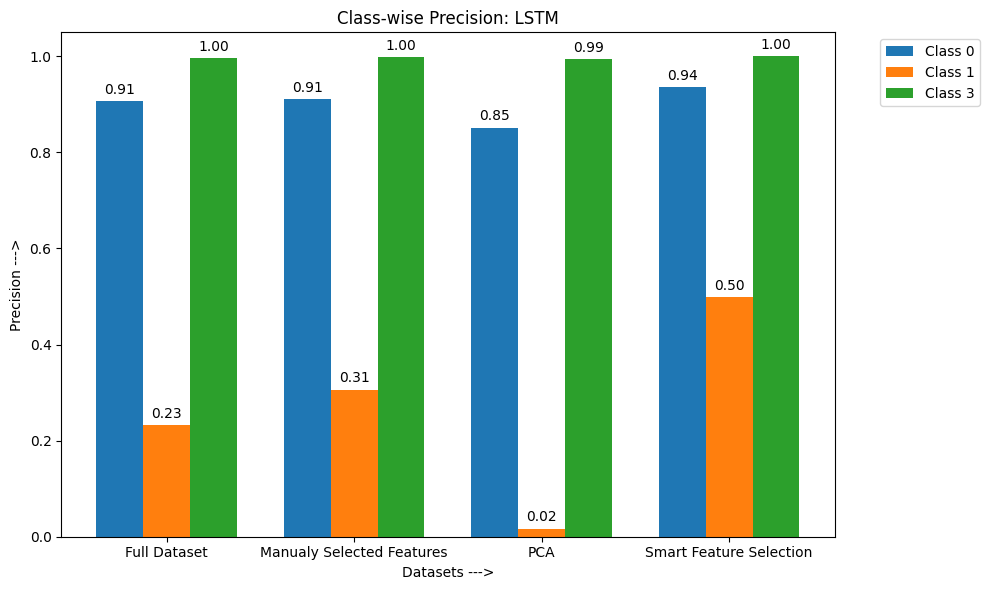

In [106]:
reload_helper()
plotter.plot_class_wise_barchart(datasets, mlp_precision, title="Class-wise Precision", y_label="Precision", model_name="MLP")
plotter.plot_class_wise_barchart(datasets, lstm_precision, title="Class-wise Precision", y_label="Precision",model_name="LSTM")

Comparing Recall Values of the models accross all datasets

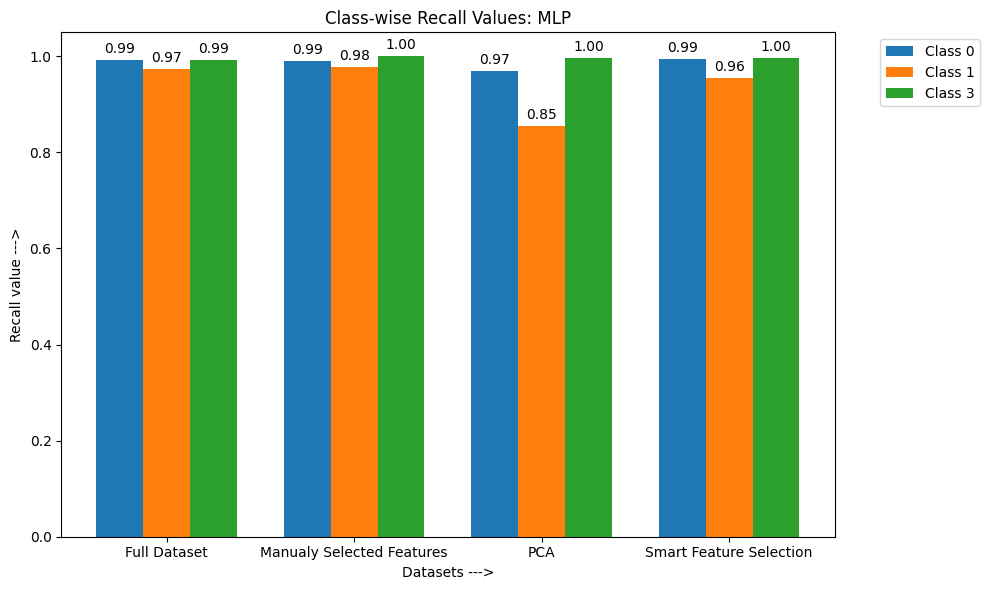

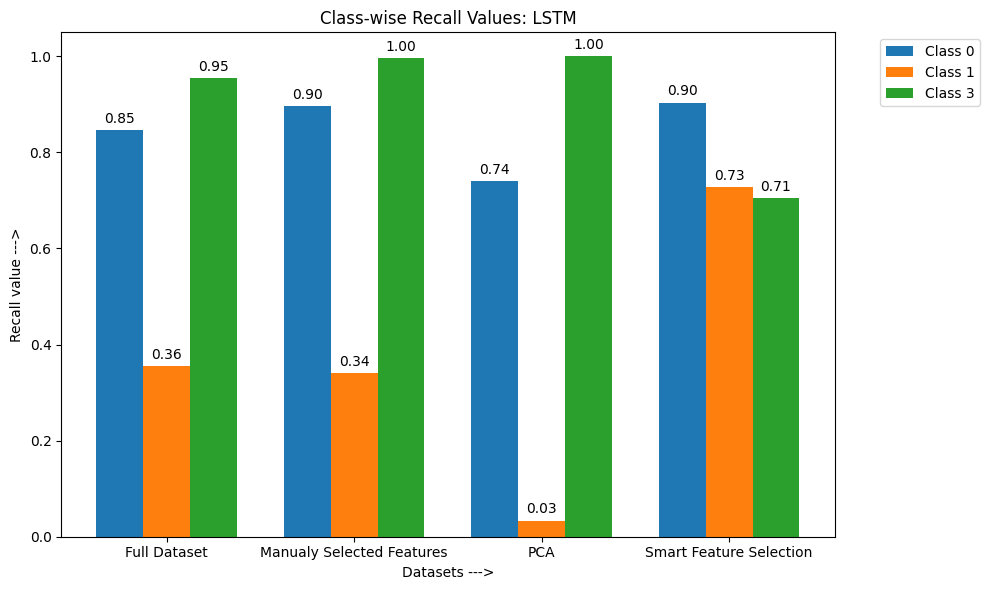

In [107]:
reload_helper()
plotter.plot_class_wise_barchart(datasets, mlp_recall, title="Class-wise Recall Values", y_label="Recall value", model_name="MLP")
plotter.plot_class_wise_barchart(datasets, lstm_recall, title="Class-wise Recall Values", y_label="Recall value",model_name="LSTM")

Analysis of the models and the dataset

Analysis of mean accuracy across datasets reveals that the: 
1. MLP consistently outperforms the Long Short-Term Memory (LSTM) model. 
2. On the full dataset, MLP achieves near-perfect accuracy (0.99), significantly higher than LSTM's 0.80. 
3. With manually selected features, MLP maintains its high accuracy (0.99), while LSTM shows slight improvement to 0.84 but still lags behind. 
4. When PCA is applied, MLP's accuracy drops slightly to 0.96, whereas LSTM's performance decreases further to 0.68, widening the gap between the two models. 
5. Finally, with smart feature selection, MLP again achieves its usual high accuracy (0.99), and LSTM improves to 0.87 but remains inferior to MLP in terms of accuracy across all datasets.

Analysis of Computational Time

1. LSTM model requires significantly more time for training and evaluation compared to the MLP. 
2. On the full dataset, LSTM takes 523.54 seconds, while MLP completes the task in just 133.92 seconds. 
3. Similarly, with manually selected features, LSTM takes 537.71 seconds, whereas MLP is much faster at 136.96 seconds. 
4. When PCA is applied, LSTM's runtime reduces to 469.51 seconds but remains far higher than MLP's efficient 132.70 seconds. 
5. Finally, with smart feature selection, LSTM takes 472.79 seconds compared to MLP's quick runtime of 129.25 seconds. Overall, MLP consistently demonstrates a significant advantage in computational efficiency across all scenarios.

Analysis of F1-Score

1. Model Stability: <br>
    A.MLP exhibits consistent performance across all classes and datasets. <br>
    B. LSTM shows significant variability, particularly under PCA and for Class 1. <br>

2. Class-Specific Performance: <br>
    A. MLP achieves uniformly high F1 scores for all classes. <br>
    B. LSTM performs well for Classes 0 and 3 but fails to handle Class 1 effectively. <br>

3. Impact of Feature Selection Methods: <br>
    A. PCA negatively impacts both models but has a more severe effect on LSTM. <br>
    B. Smart Feature Selection improves LSTM's performance but still falls short compared to MLP.

Analysis of Standard Deviation

1. MLP exhibits extremely low standard deviation across all datasets, indicating consistent and stable performance <br>
2. LSTM shows significantly higher standard deviation across all datasets, reflecting greater variability in its predictions <br>
3. MLP consistently has near-zero standard deviation, indicating reliable and stable predictions. <br>
4. LSTM's higher standard deviation points to inconsistent performance across datasets.<br>
5. PCA results in the highest variability for LSTM (0.36), while Smart Feature Selection reduces it to a more manageable level (0.07). <br>
6. MLP remains unaffected by feature selection methods, maintaining low variability throughout. <br>


Analysis of Precision 

1. MLP consistently achieves high precision across all classes and feature selection methods, except for a slight drop in precision for Class 1 with PCA. <br>

2. LSTM struggles significantly with precision for Class 1 across all methods, but Smart Feature Selection improves its performance for this class. <br>

3. PCA negatively impacts both models, especially LSTM, where precision for Class 1 drops to near-zero (0.02). <br>


Analysis of Recall values

1. MLP Consistently high recall values accross all feature selection methods <br>
2. PCA reduces the recall of Class 1 significantly compared to other methods <br>
3. Smart Feature Selection provides the best balance, achieving perfect recall for Classes (0 and 3) and near-perfect results for Class (1) <br>
4. Struggles with low recall for Class (1) across all methods.
5. PCA performs poorly, especially for Classes (0) and (1), while maintaining good results only for Class (3).

Comparison of Datasets

1. The Full Dataset provides the highest recall and accuracy for both models, with MLP achieving near-perfect scores across all classes and LSTM performing well for Classes 0 and 3 but struggling significantly with Class 1. <br>

2. Manually Selected Features maintain MLP's strong performance with minimal variation, while LSTM shows slight improvement in recall for Class 1 but remains less effective overall. <br>

3. The PCA dataset results in the most significant performance degradation for both models, particularly for LSTM, where recall for Class 1 drops to near-zero. This indicates that PCA fails to preserve critical features necessary for distinguishing certain classes, especially for LSTM. <br>

4. Finally, Smart Feature Selection emerges as the most balanced approach, enabling MLP to maintain its high accuracy and recall while significantly improving LSTM's performance on Class 1 (recall rises to 0.73). However, even with Smart Feature Selection, LSTM's overall performance remains inferior to MLP across all metrics. 

Conclusion

MLP is the superior model overall due to its high accuracy, computational efficiency, stable predictions, and balanced class-wise performance across all datasets and feature selection methods. While LSTM can benefit from smart feature selection to improve its results slightly, it remains less reliable and slower than MLP. <br>

Smart Feature Selection emerges as the best one comparatively accross all datasets

xxxx--------------------------THE END----------------------xxxx